In [60]:
!pip install polars beautifulsoup4 splinter selenium scikit-learn matplotlib altair seaborn vl-convert-python tensorflow keras-tuner pandas pyarrow

In [61]:
#Data Manipulation and display toools
import polars as pl
from polars.exceptions import InvalidOperationError
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
# Pandas is necessary for ease of use with the ML libraries
# Polars does not use indexing and therefore does not always follow the data format properly
# Particularly the format:
#   {tablename: {index_val1: [row1_values]},
#               {index_val2: [row2_values]}}
import pandas as pd
# pyarrow necessary for polars.to_pandas()
import pyarrow
from IPython.display import display_html 

# Web scraping tools
import re
from bs4 import BeautifulSoup
# Uses firefox browser
from splinter import Browser
import time

# Data preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Machine learning tools
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score

#Necessary for tensorflow on my machine due to distutils being depreciated
import setuptools
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model, Sequential
from tensorflow.keras import optimizers
import keras_tuner as kt

random_state = 2112250415

# Loading Data

In [62]:
cwd = pathlib.Path.cwd()

if cwd.name == 'Mild-Steel-Tempering':
    print("Path is project root")
else:
    print("Please correct current working directory to the project root")


Path is project root


In [63]:
resources_path = pathlib.PurePath(pathlib.PurePath(cwd), 'resources', 'multiout')
resources_path

PurePosixPath('/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/resources/multiout')

In [64]:
images_path = pathlib.PurePath(pathlib.PurePath(cwd), 'images', 'multiout')
images_path

PurePosixPath('/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/images/multiout')

### Many alloy composition columns were parsed incorrectly and failing to load

Several weight percent columns were parsed as int automatically due to having "0" for many initial rows. 

All weight percent columns should be parsed as float. 

In [65]:
data_path = f"{resources_path.parent}/Raiipa-tempering-data.csv"
schema_overrides = {"C (%wt)" : pl.Float64,
"Mn (%wt)" : pl.Float64,
"P (%wt)" : pl.Float64,
"S (%wt)" : pl.Float64,
"Si (%wt)" : pl.Float64,
"Ni (%wt)" : pl.Float64,
"Cr (%wt)" : pl.Float64,
"Mo (%wt)" : pl.Float64,
"V (%wt)" : pl.Float64,
"Al (%wt)" : pl.Float64,
"Cu (%wt)" : pl.Float64}

df_data = pl.read_csv(data_path, schema_overrides=schema_overrides)
df_data.glimpse()

Rows: 1466
Columns: 17
$ Source                                  <str> 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956'
$ Steel type                              <str> 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026'
$ Initial hardness (HRC) - post quenching <str> '?', '?', '?', '?', '?', '?', '?', '?', '?', '?'
$ Tempering time (s)                      <i64> 600, 600, 600, 600, 600, 600, 600, 600, 600, 600
$ Tempering temperature (ºC)              <f64> 204.4, 260.0, 315.6, 371.1, 426.7, 482.2, 537.8, 593.3, 648.9, 704.4
$ C (%wt)                                 <f64> 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25
$ Mn 

In [66]:
# save initial columns names as they are very descriptive and may be useful later
initial_column_names = df_data.columns
initial_column_names

['Source',
 'Steel type',
 'Initial hardness (HRC) - post quenching',
 'Tempering time (s)',
 'Tempering temperature (ºC)',
 'C (%wt)',
 'Mn (%wt)',
 'P (%wt)',
 'S (%wt)',
 'Si (%wt)',
 'Ni (%wt)',
 'Cr (%wt)',
 'Mo (%wt)',
 'V (%wt)',
 'Al (%wt)',
 'Cu (%wt)',
 'Final hardness (HRC) - post tempering']

# Cleaning
Many columns need renaming for ease of manipulation

Columns need datatypes correction
 'Initial hardness (HRC) - post quenching' needs datatype correction. ? is NA value


In [67]:
dict_new_cnames = {}
for og_name in initial_column_names:
    # replace filler in hardness columns
    new_name = og_name.replace(' - ', '')
    
    # Handle units
    try:
        #if alloy weight percent remove units and return only elemental symbol
        if re.search(r"\(%wt\)", og_name):
            new_name = og_name.split(' ')[0]
            #skip the rest of the try block that will re_add the units to the end
            pass
        else: 
            #If not elemental composition, lowercase the string
            new_name = new_name.lower()
        # regex find the units inside the parenthesis, of the original name, not the lowercased new name
        # This lines breaks and goes to except if there is no units
        unit = re.search(r'\((\w+)\)', og_name).group(1)
        # replace the unit parenthesis string with parenthesis with an empty string
        new_name = re.sub(r"\(.+\)", "", new_name)
        # trim to whitespace end characters left by some unit removals
        new_name = new_name.rstrip()
        # append the unit string to the end of the processed name
        new_name = f"{new_name}_{unit}"
    except:
        # skip unit processing on names with no units denoted by parenthesis
        pass

    # Strip away special characters
    new_name = new_name.encode("ascii", errors="ignore").decode()
    #replace all whitespace with underscores
    new_name = new_name.replace(' ', '_')
    #add the name to the rename dict
    dict_new_cnames[og_name] = new_name
dict_new_cnames


{'Source': 'source',
 'Steel type': 'steel_type',
 'Initial hardness (HRC) - post quenching': 'initial_hardness_post_quenching_HRC',
 'Tempering time (s)': 'tempering_time_s',
 'Tempering temperature (ºC)': 'tempering_temperature_C',
 'C (%wt)': 'C',
 'Mn (%wt)': 'Mn',
 'P (%wt)': 'P',
 'S (%wt)': 'S',
 'Si (%wt)': 'Si',
 'Ni (%wt)': 'Ni',
 'Cr (%wt)': 'Cr',
 'Mo (%wt)': 'Mo',
 'V (%wt)': 'V',
 'Al (%wt)': 'Al',
 'Cu (%wt)': 'Cu',
 'Final hardness (HRC) - post tempering': 'final_hardness_post_tempering_HRC'}

In [68]:
df_clean_cnames = df_data.rename(dict_new_cnames)

## Clean data types and column values

In [69]:
count_of_qmark = df_clean_cnames['initial_hardness_post_quenching_HRC'].value_counts()\
    .filter(pl.col('initial_hardness_post_quenching_HRC') == "?")\
        .select("count").item()


In [70]:
percent_intial_hardness_unknown = count_of_qmark / int(df_clean_cnames['initial_hardness_post_quenching_HRC'].shape[0])
print(f"Unknown initial hardness: {round(percent_intial_hardness_unknown, 2) * 100:.0f}%")


Unknown initial hardness: 65%


In [71]:
df_clean_cnames.tail(3)


source,steel_type,initial_hardness_post_quenching_HRC,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,500.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,32.0
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,600.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,23.0
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,700.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,4.5


In [72]:
df_clean_cnames["initial_hardness_post_quenching_HRC"].value_counts().sort('count', descending=True).head(3)

initial_hardness_post_quenching_HRC,count
str,u32
"""?""",949
"""66.5""",90
"""63.3""",51


In [73]:
df_clean = df_clean_cnames.with_columns(pl.col('initial_hardness_post_quenching_HRC').cast(pl.Float64, strict=False))


In [74]:
df_clean["initial_hardness_post_quenching_HRC"].value_counts().sort('count', descending=True).head(3)

initial_hardness_post_quenching_HRC,count
f64,u32
null,949
66.5,90
63.3,51


In [75]:
df_clean.describe()

statistic,source,steel_type,initial_hardness_post_quenching_HRC,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1466""","""1466""",517.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0
"""null_count""","""0""","""0""",949.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,61.493617,21969.754434,422.024147,0.511583,0.74073,0.017236,0.023802,0.239379,0.362838,0.389696,0.080232,0.005457,0.034379,0.005986,41.468008
"""std""",null,null,5.656383,34177.623863,176.088041,0.224354,0.252913,0.007966,0.007967,0.239193,0.810091,0.480721,0.121422,0.02905,0.20534,0.019085,14.079248
"""min""","""Grange and Baughman, 1956""","""0,31%C - plain carbon steel""",46.5,10.0,100.0,0.25,0.3,0.007,0.005,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.9
"""25%""",null,null,58.8,600.0,260.0,0.37,0.6,0.012,0.018,0.16,0.0,0.02,0.0,0.0,0.0,0.0,32.1
"""50%""",null,null,63.1,3600.0,426.7,0.42,0.74,0.017,0.024,0.21,0.01,0.06,0.0,0.0,0.0,0.0,43.1
"""75%""",null,null,66.5,14400.0,593.3,0.56,0.8,0.019,0.029,0.24,0.06,0.8,0.22,0.0,0.0,0.0,51.8
"""max""","""Penha, 2010""","""Nitriding Steel """,67.0,115200.0,704.4,1.15,1.85,0.054,0.055,1.62,3.41,1.57,0.36,0.16,1.26,0.08,68.5


# Making steel types values searchable on AZoM.com
Steel types that do not include AISI and a code are not searchable in steel databased and need manual renaming

Exmaple: "0,74%C - plain carbon steel" is a AISI 1074 steel. Confirmed via elemental composition on https://www.azom.com/article.aspx?ArticleID=6558


In [76]:
steel_identifiers = ["steel_type", "source"]
df_clean[steel_identifiers].unique().shape

(36, 2)

## Renaming all possible steels so they are searchable

1945 source

I can not access source papers. Making a best guess of steel grade from elemental composition

I assume some alloying elements are a bit strange due to wartime shortages and potential contamination between alloys due to the push to increasew prodiction.

### additional Justifications are inline

In [77]:
#1945 source...
# I can not access source for the 1945 paper on these
# I assume they alloying elements are a bit strange due to wartime shortages
# and potentially contamination between alloys due to the push to increasew prodiction
dict_rename = {'0,98%C - plain carbon steel': 'AISI 1095', # copper and Cr, probably intentional?
                   '1,15%C - plain carbon steel': 'AISI 1095', # small chromium impurity?
                   '0,74%C - plain carbon steel': 'AISI 1074 Carbon Steel', 
                   '0,56%C - plain carbon steel': 'AISI 1055', # small chromium impurity?
                   '0,89%C - plain carbon steel': 'AISI 1090', # Cu discounted as impurity
                   'Nitriding Steel ': 'Non-searchable', 
                   '0,31%C - plain carbon steel': 'AISI 1030', # AISI 1030, Cr impurity
                   # These 4 steels are automotive steels and free access to the properties is unavailable to my knowledge
                   "AISI-SAE 9264" : 'AISI-SAE 9254', # access limited, may be AISI-SAE 9264 , not in AZoM
                   "AISI-SAE 2340" : 'Non-searchable', # access limited, may be SAE J2340, not in AZoM
                   "AISI-SAE 3140" : 'Non-searchable', # Not in AZoM. elemental match to SAE 3140 https://www.steel-grades.com/metals/18/5155/-SAE-3140.html
                   "AISI-SAE 4068" : 'Non-searchable', # access limited, may be SAE 4068, not in AZoM
                
                    "AISI-SAE 4640" : "AISI 4640",
                   "AISI-SAE 4047" : "AISI 4047",
                   "AISI-SAE 1049" : "AISI 1049",
                   "AISI-SAE 6145" : "AISI 6145",
                   "AISI-SAE E52100" : "AISI 52100"} # # Not in AZoM elemental match to  SAE 4068https://www.steel-grades.com/Steel-Grades/Carbon-Steel/SAE-4068-.html

In [78]:
series_searchable_steel = df_clean.clone()
renamed = series_searchable_steel['steel_type'].replace(dict_rename)
series_searchable_steel = series_searchable_steel.with_columns(searchable = renamed)

In [79]:
series_to_search = series_searchable_steel['searchable'].unique()
steels_to_search = series_to_search.filter(series_to_search.eq('Non-searchable').not_())
steels_to_search

searchable
str
"""AISI-SAE 1080"""
"""AISI-SAE 9254"""
"""AISI 1049"""
"""AISI-SAE 1040"""
"""AISI-SAE 6150"""
…
"""AISI-SAE 1035"""
"""AISI 6145"""
"""AISI-SAE 1045"""


## Save Searchable steel
Checkpoint so that the code to this point does not need to be run every time

In [80]:
path_save_searchable = f"{resources_path.parent}/searchable_steels.csv"
pl.DataFrame(steels_to_search).write_csv(path_save_searchable)

# Web Scraping

Not all steels are documented in a way that allowed them to be searched.

Several steels are denoted by "x.xx% plain carbon steel." These are not standard searchable, except manually. A manual search was done, a few of the older steels do not conform to any known standard, particularly the steels with copper present. 

It is speculated that these are wartime steels from WW2 and alloying was done to reach the desired properties, not necessarily to adhere to a standard, especially considering there were material shortages, especially in some preferred alloying elements. The manufacturing crucibles also could not have been fully cleaned between batches of different material, resulting in contaimination between, say, a brass batch and a steel batch, resulting in elevated copper concentrations in the steel.

Some SAE are not available on the free services and were also not incuded in the final dataset.
---

Two stages of scraping are necessary.

AZoM.com does not have data on all steels, neither does MakeItFrom.com.

Scraping from both will be done to get the most infortmation possible. 

Using both we can scrape additional data for 29 of the 36 steels present in the Raiipa dataset. 

1286 rows retained of the original 1467.

In [81]:
len([print(steel) for steel in steels_to_search])

AISI-SAE 1080
AISI-SAE 9254
AISI 1049
AISI-SAE 1040
AISI-SAE 6150
AISI 4047
AISI-SAE 1050
AISI 4640
AISI 52100
AISI-SAE 1042
AISI 1030
AISI-SAE 5160
AISI 1095
AISI-SAE 1335
AISI-SAE 1030
AISI-SAE 4037
AISI-SAE 4027
AISI-SAE 1038
AISI 1074 Carbon Steel
AISI-SAE 1026
AISI-SAE 1065
AISI-SAE 5140
AISI-SAE 4140
AISI-SAE 4340
AISI-SAE 1035
AISI 6145
AISI-SAE 1045
AISI 1090
AISI 1055


29

## Scraping AZoM.com

In [82]:
browser = Browser('firefox')
base_url = "https://www.azom.com"
search_path = "/search.aspx?q="

In [83]:
# Search the steel 
def get_soup(soup):
    search_result = soup.find('div', class_='resultsContainer')
    first_item = search_result.find('a')
    # https://pytutorial.com/get-element-href-beautifulsoup/
    steel_link = first_item.get('href')
    time.sleep(0.15)
    browser.visit(f"{base_url}{steel_link}")
    soup2 = BeautifulSoup(browser.html, 'html.parser')
    return soup2


In [84]:
# already have elemental composition
# property - metric - imperial
# table_elements = tables[0]
# table_phys_props = tables[1]
# table_mecha_props = tables[2]
# table_therm_props = tables[3]
# table_other_desigs = tables[4]
#parse tables
def get_tables(soup):
    tables = []
    # parse all tables in the
    for html_table in soup.find_all('table'):
        table = []
        # parse rows in the table
        for tr in html_table.find_all('tr'):
            row = []
            #parse data cells in the row
            for t in tr.find_all(['th', 'td']):
                text = t.get_text(strip=True)
                #add data to row
                row.append(text)
            #add row to table
            table.append(row)
    #returns a list of list of lists
        tables.append(table)
    return tables
    

In [85]:
def make_dfs(lolols):
    tables = []
    # convert the list of lists to a dataframe
    for lol in lolols:
        try:
            df = pl.DataFrame(lol, orient='row')
            # rename columns using first row
            # https://stackoverflow.com/questions/75187317/how-to-rename-column-names-with-first-row-in-polars
            # [1:] removes the first row that replaced the column names 
            df = df.rename(df.head(1).to_dicts().pop())[1:]
            # add the dataframe to the list of tables on for this steel
            tables.append(df)
        except:
            tables.append(lol)
    return tables

In [86]:
dict_steel_tables = {}
for steel in steels_to_search:
    try:
        print("Working on:", steel)
        #search AZoM for the steel
        browser.visit(f"{base_url}{search_path}{steel}")
        soup_search = BeautifulSoup(browser.html, 'html.parser')
    
        #takes soup html and returns list of lists
        soup = get_soup(soup_search)
        lolols = get_tables(soup)
        dict_steel_tables[steel] = make_dfs(lolols)
        # tables list of lists and returns a dictionary
        # robots.txt indicates Crawl-delay: 120
        time.sleep(0.15)
    except: 
        dict_steel_tables[steel] = []

Working on: AISI-SAE 1080
Working on: AISI-SAE 9254
Working on: AISI 1049
Working on: AISI-SAE 1040
Working on: AISI-SAE 6150
Working on: AISI 4047
Working on: AISI-SAE 1050
Working on: AISI 4640
Working on: AISI 52100
Working on: AISI-SAE 1042
Working on: AISI 1030
Working on: AISI-SAE 5160
Working on: AISI 1095
Working on: AISI-SAE 1335
Working on: AISI-SAE 1030
Working on: AISI-SAE 4037
Working on: AISI-SAE 4027
Working on: AISI-SAE 1038
Working on: AISI 1074 Carbon Steel
Working on: AISI-SAE 1026
Working on: AISI-SAE 1065
Working on: AISI-SAE 5140
Working on: AISI-SAE 4140
Working on: AISI-SAE 4340
Working on: AISI-SAE 1035
Working on: AISI 6145
Working on: AISI-SAE 1045
Working on: AISI 1090
Working on: AISI 1055


In [87]:
dict_steel_tables

{'AISI-SAE 1080': [shape: (5, 2)
  ┌────────────────┬─────────────┐
  │ Element        ┆ Content     │
  │ ---            ┆ (%)         │
  │ str            ┆ ---         │
  │                ┆ str         │
  ╞════════════════╪═════════════╡
  │ Iron, Fe       ┆ 98.0 - 99.0 │
  │ Carbon, C      ┆ 0.75 - 0.88 │
  │ Manganese, Mn  ┆ 0.60 - 0.90 │
  │ Sulfur, S      ┆ 0.05 (max)  │
  │ Phosphorous, P ┆ 0.04 (max)  │
  └────────────────┴─────────────┘,
  shape: (1, 3)
  ┌────────────┬────────────────┬────────────────────┐
  │ Properties ┆ Metric         ┆ Imperial           │
  │ ---        ┆ ---            ┆ ---                │
  │ str        ┆ str            ┆ str                │
  ╞════════════╪════════════════╪════════════════════╡
  │ Density    ┆ 7.7-8.03 g/cm3 ┆ 0.278-0.290 lb/in³ │
  └────────────┴────────────────┴────────────────────┘,
  shape: (2, 3)
  ┌─────────────────┬─────────────┬─────────────────┐
  │ Properties      ┆ Metric      ┆ Imperial        │
  │ ---             

# Converting AZoM Scraped Data to one dataframe

## Working with list of tables

Must confirma all tables were sucesffuly made into polars tables

Must reduce the numebr of tables to only those we are concerned with

* Remove "Other Designations" tables, including those that did not get sucessfully converted to a polars dataframe (table 4)

* Remove tables with properties that are not commonly present (thermal propterties table 3)

* Remove elemental compositions, already present in the data (table 0)

* Physical and mechanical properties are desired (tables 1,2)

In [88]:
dict_steel_tables_keep = {}
bool_check = True
polars_check = True 
for steel, tables in dict_steel_tables.items():
    all_polars = True
    count_polars = 0
    for table in tables:
        if isinstance(table, pl.DataFrame): 
            count_polars += 1 
    if count_polars != len(tables):
        all_polars = False
    if not (bool_check and all_polars):
        bool_check = False
    print("All polars?", all_polars, '|', len(tables), "Tables | Steel:", steel)
    dict_steel_tables_keep[steel] = tables[1:3]
print(polars_check)

All polars? True | 4 Tables | Steel: AISI-SAE 1080
All polars? True | 0 Tables | Steel: AISI-SAE 9254
All polars? True | 3 Tables | Steel: AISI 1049
All polars? True | 4 Tables | Steel: AISI-SAE 1040
All polars? True | 5 Tables | Steel: AISI-SAE 6150
All polars? True | 4 Tables | Steel: AISI 4047
All polars? True | 4 Tables | Steel: AISI-SAE 1050
All polars? True | 4 Tables | Steel: AISI 4640
All polars? True | 4 Tables | Steel: AISI 52100
All polars? True | 4 Tables | Steel: AISI-SAE 1042
All polars? True | 5 Tables | Steel: AISI 1030
All polars? True | 4 Tables | Steel: AISI-SAE 5160
All polars? True | 5 Tables | Steel: AISI 1095
All polars? True | 4 Tables | Steel: AISI-SAE 1335
All polars? True | 5 Tables | Steel: AISI-SAE 1030
All polars? True | 4 Tables | Steel: AISI-SAE 4037
All polars? True | 4 Tables | Steel: AISI-SAE 4027
All polars? True | 4 Tables | Steel: AISI-SAE 1038
All polars? True | 3 Tables | Steel: AISI 1074 Carbon Steel
All polars? True | 5 Tables | Steel: AISI-SAE

### Check if all kept tables are good

Confirm all are polars dataframes

Look at the shape of all of them and determine which will be limiting

In [89]:
dict_phys_props = {}
dict_mech_props = {}

polars_check = True 
for steel, tables in dict_steel_tables_keep.items():
    try:
        all_polars = True
        count_polars = 0
        for table in tables:
            if isinstance(table, pl.DataFrame): 
                count_polars += 1 
        if count_polars != len(tables):
            all_polars = False
        if not (bool_check and all_polars):
            bool_check = False
        print("All polars?", all_polars, '|', len(tables), "Tables | Steel:", steel)

        phys_props = tables[0]
        mech_props = tables[1]
        print("Physical properties:", phys_props.shape, "| Properties head(1)", phys_props.select(pl.col('Properties').head(1)) )
        print("Mechanical propsshape:", mech_props.shape, "| Properties head(1)", mech_props.select(pl.col('Properties').head(1)) )
        dict_phys_props[steel] = phys_props
        dict_mech_props[steel] = mech_props
    except:
        dict_phys_props[steel] = pl.DataFrame({'Properties' : [], 'Metric' : []})
        dict_mech_props[steel] = pl.DataFrame({'Properties' : [], 'Metric' : []})

print("All Polars?", polars_check)

All polars? True | 2 Tables | Steel: AISI-SAE 1080
Physical properties: (1, 3) | Properties head(1) shape: (1, 1)
┌────────────┐
│ Properties │
│ ---        │
│ str        │
╞════════════╡
│ Density    │
└────────────┘
Mechanical propsshape: (2, 3) | Properties head(1) shape: (1, 1)
┌─────────────────┐
│ Properties      │
│ ---             │
│ str             │
╞═════════════════╡
│ Elastic modulus │
└─────────────────┘
All polars? True | 0 Tables | Steel: AISI-SAE 9254
All polars? True | 2 Tables | Steel: AISI 1049
Physical properties: (1, 3) | Properties head(1) shape: (1, 1)
┌────────────┐
│ Properties │
│ ---        │
│ str        │
╞════════════╡
│ Density    │
└────────────┘
Mechanical propsshape: (2, 3) | Properties head(1) shape: (1, 1)
┌─────────────────┐
│ Properties      │
│ ---             │
│ str             │
╞═════════════════╡
│ Elastic modulus │
└─────────────────┘
All polars? True | 2 Tables | Steel: AISI-SAE 1040
Physical properties: (2, 3) | Properties head(1) shape

# Filter for complete data, and select unit standard

Kpep only property and metric column from both sets of tables

Find which properties are present in all tables of each type

In [90]:
def remove_imperial(property_dict):
    new_dict = {}
    for key, table in property_dict.items():
        new_dict[key] = table.select(["Properties", "Metric"])
    return new_dict

dict_phys_props =  remove_imperial(dict_phys_props)
dict_mech_props = remove_imperial(dict_mech_props)


dict_phys_props['AISI-SAE 1050']

Properties,Metric
str,str
"""Density""","""7.85 g/cm3"""


# Properties to keep

Only properties present in all metals are the following:

Physical
* Density

Mechanical
* Elastic modulus
* Poisson's ratio

### Treat 2 values that do not have spaces seperating the units from the digits

In [91]:
print(dict_phys_props['AISI 1074 Carbon Steel'][0, "Metric"])
print(dict_mech_props['AISI-SAE 1065'][2, "Metric"])

7.7-8.03g/cm3
200GPa


In [92]:
#fix formatting in single cell. Did not incude a space 
# Could handle with regex, but onyl 2 errors are present so manual handling suffices
# The project data has fixed scope, so this is acceptable.
# arrives as '7.7-8.03g/cm3'
dict_phys_props['AISI 1074 Carbon Steel'][0, "Metric"] = '7.7-8.03 g/cm3'
# arrives as '200GPa'
dict_mech_props['AISI-SAE 1065'][2, "Metric"] = '200 GPa'
dict_mech_props['AISI-SAE 1065']

Properties,Metric
str,str
"""Tensile strength, ultimate""","""635 MPa"""
"""Tensile strength, yield""","""490 MPa"""
"""Modulus of elasticity""","""200 GPa"""
"""Bulk modulus (typical for stee…","""140 GPa"""
"""Shear modulus (typical for ste…","""80 GPa"""
…,…
"""Hardness, Knoop (converted fro…","""209"""
"""Hardness, Rockwell B (converte…","""90"""
"""Hardness, Rockwell C (converte…","""10"""


## Process Density into a df

In [93]:
s_steel = pl.Series(name = 'steel', dtype= pl.String)
s_density = pl.Series(name = 'density', dtype= pl.String)
s_unit = pl.Series(name = 'units_density', dtype= pl.String)

for steel, table in dict_phys_props.items():
    try:
        #select only the  cell of interest
        df_density = table.filter(pl.col('Properties').str.contains("Density"))['Metric'].str.split(' ')
        density = df_density.list.get(0)
        unit = df_density.list.get(1)
        # Make a series of all 3
        s_steel.extend(pl.Series(name = 'steel', values = [steel]))
        s_density = s_density.extend(density)
        s_unit = s_unit.extend(unit)
    except:
        print("Failed on", steel)

Failed on AISI-SAE 9254


In [94]:
df_steel_properties = pl.DataFrame([s_steel, s_density, s_unit])
df_steel_properties

steel,density,units_density
str,str,str
"""AISI-SAE 1080""","""7.7-8.03""","""g/cm3"""
"""AISI 1049""","""7.7-8.03""","""g/cm3"""
"""AISI-SAE 1040""","""7.845""","""g/cc"""
"""AISI-SAE 6150""","""7.85""","""g/cm3"""
"""AISI 4047""","""7.85""","""g/cm3"""
…,…,…
"""AISI-SAE 1035""","""7.85""","""g/cm3"""
"""AISI 6145""","""7.75""","""g/cm3"""
"""AISI-SAE 1045""","""7.87""","""g/cm3"""


## Process mechanical properties

In [95]:
def grab_property(table, property):
    s_result = table.filter(pl.col('Properties')\
                            .str.to_lowercase()\
                                .str.contains(property))\
                                ['Metric']
    return s_result

In [96]:
def get_oobT(df, index):
    return df.list.get(index, null_on_oob=True)

In [97]:
# list of tuples if data was sucessfully scraped from AZoM
azom_sucessful = {'steel':[],'AZoM-Successful':[]}
list_of_scraped = [("steel", "pr", "em", "em_unit", "ys", "ys_unit", "uts", "uts_unit")]

for steel, table in dict_mech_props.items():
    pr = None
    em = None
    em_unit = None
    ys = None
    ys_unit = None
    uts = None
    uts_unit = None

    try:
        # Grab values and split into units where necessary
        #poisson's ratio
        pr = grab_property(table, "poisson")

        #elastic modulus
        df_em = grab_property(table, "elastic").str.split(' ')
        em = get_oobT(df_em, 0)
        em_unit = get_oobT(df_em, 1)
        # em = df_em.list.get(0, null_on_oob=True)
        # em_unit = df_em.list.get(1, null_on_oob=True)

        # grab yield strength
        df_ys = grab_property(table, "yield").str.split(' ')
        ys = get_oobT(df_ys, 0)
        ys_unit = get_oobT(df_ys, 1)

        # grab strength value that is not yield strength.
        # Tensile strength or ultimate yield strength or ultimate tensile strength. All the same measurement
        df_uts = table.filter(pl.col('Properties').str.to_lowercase().str.contains("strength") & 
                            pl.col('Properties').str.to_lowercase().str.contains("yield").not_())\
                                ['Metric'].str.split(' ')
        uts = get_oobT(df_uts, 0)
        uts_unit = get_oobT(df_uts, 1)
    
        # Make a tuple for each row
        # If this fails it will be an IndexError and go to the except
        row = (steel, pr[0], em[0], em_unit[0], ys[0], ys_unit[0], uts[0], uts_unit[0])

        list_of_scraped.append(row)
        azom_sucessful['steel'].append(steel)
        azom_sucessful['AZoM-Successful'].append(True)
        
    except (IndexError, InvalidOperationError):
        print("Failed on", steel)
        azom_sucessful['steel'].append(steel)
        azom_sucessful['AZoM-Successful'].append(False)

df_AZoM_successfull = pl.DataFrame(azom_sucessful)
df_AZoM_successfull.filter(pl.col('AZoM-Successful')==False)

Failed on AISI-SAE 1080
Failed on AISI-SAE 9254
Failed on AISI 1049
Failed on AISI 4047
Failed on AISI 52100
Failed on AISI-SAE 1042
Failed on AISI-SAE 1335
Failed on AISI-SAE 4037


steel,AZoM-Successful
str,bool
"""AISI-SAE 1080""",false
"""AISI-SAE 9254""",false
"""AISI 1049""",false
"""AISI 4047""",false
"""AISI 52100""",false
"""AISI-SAE 1042""",false
"""AISI-SAE 1335""",false
"""AISI-SAE 4037""",false


## Convert to dataframes and save

Checkpoint for continued work in this file so the scraping does not need to be done every time.

In [98]:
ttCdf_temp = pl.DataFrame(list_of_scraped, orient='row')
# rename columns using first row
# https://stackoverflow.com/questions/75187317/how-to-rename-column-names-with-first-row-in-polars
# [1:] removes the first row that replaced the column names 
ttCdf_temp = ttCdf_temp.rename(ttCdf_temp.head(1).to_dicts().pop())[1:]
ttCdf_temp.tail(3)

steel,pr,em,em_unit,ys,ys_unit,uts,uts_unit
str,str,str,str,str,str,str,str
"""AISI-SAE 1045""","""0.29""","""200""","""GPa""","""450""","""MPa""","""585""","""MPa"""
"""AISI 1090""","""0.27-0.30""","""190-210""","""GPa""","""540""","""MPa""","""696""","""MPa"""
"""AISI 1055""","""0.27-0.30""","""190-210""","""GPa""","""560""","""MPa""","""660""","""MPa"""


In [99]:
df_steel_properties = df_steel_properties.join(ttCdf_temp, on='steel', how='inner')
df_steel_properties.write_csv(f'{resources_path.parent}/scraped_properties.csv')
df_steel_properties


steel,density,units_density,pr,em,em_unit,ys,ys_unit,uts,uts_unit
str,str,str,str,str,str,str,str,str,str
"""AISI-SAE 1040""","""7.845""","""g/cc""","""0.27-0.30""","""190-210""","""GPa""","""415""","""MPa""","""620""","""MPa"""
"""AISI-SAE 6150""","""7.85""","""g/cm3""","""0.27 – 0.30""","""190-210""","""GPa""","""415""","""MPa""","""670""","""MPa"""
"""AISI-SAE 1050""","""7.85""","""g/cm3""","""0.27-0.30""","""190-210""","""GPa""","""580""","""MPa""","""690""","""MPa"""
"""AISI 4640""","""7.75""","""g/cm3""","""0.27-030""","""201-209""","""GPa""","""1103""","""MPa""","""1276""","""MPa"""
"""AISI 1030""","""7.85""","""g/cc""","""0.27-0.30""","""190-210""","""GPa""","""440""","""MPa""","""525""","""MPa"""
…,…,…,…,…,…,…,…,…,…
"""AISI-SAE 1035""","""7.85""","""g/cm3""","""0.27-0.30""","""190-210""","""GPa""","""370""","""MPa""","""585""","""MPa"""
"""AISI 6145""","""7.75""","""g/cm3""","""0.27-030""","""201-209""","""GPa""","""1165""","""MPa""","""1213""","""MPa"""
"""AISI-SAE 1045""","""7.87""","""g/cm3""","""0.29""","""200""","""GPa""","""450""","""MPa""","""585""","""MPa"""


In [100]:
resources_path

PurePosixPath('/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/resources/multiout')

In [101]:
s_AZOM_unsuccessful = df_AZoM_successfull.filter(pl.col('AZoM-Successful')==False)['steel']
pl.DataFrame(s_AZOM_unsuccessful).write_csv(f'{resources_path.parent}/MIF_search.csv')

# Process units from scraped AZoM data

Ensure all units are base units and the same down each column

In [102]:
data_path = f"{resources_path.parent}/scraped_properties.csv"
df_scraped = pl.read_csv(data_path)
df_scraped.glimpse()

Rows: 21
Columns: 10
$ steel         <str> 'AISI-SAE 1040', 'AISI-SAE 6150', 'AISI-SAE 1050', 'AISI 4640', 'AISI 1030', 'AISI-SAE 5160', 'AISI 1095', 'AISI-SAE 1030', 'AISI-SAE 4027', 'AISI-SAE 1038'
$ density       <str> '7.845', '7.85', '7.85', '7.75', '7.85', '7.85', '7.85', '7.85', '7.85', '7.845'
$ units_density <str> 'g/cc', 'g/cm3', 'g/cm3', 'g/cm3', 'g/cc', 'g/cm3', 'g/cm3', 'g/cc', 'g/cm3', 'g/cm3'
$ pr            <str> '0.27-0.30', '0.27 – 0.30', '0.27-0.30', '0.27-030', '0.27-0.30', '0.27 – 0.30', '0.27-0.30', '0.27-0.30', '0.27-0.30', '0.27-0.30'
$ em            <str> '190-210', '190-210', '190-210', '201-209', '190-210', '190-210', '190-210', '190-210', '190-210', '190-210'
$ em_unit       <str> 'GPa', 'GPa', 'GPa', 'GPa', 'GPa', 'GPa', 'GPa', 'GPa', 'GPa', 'GPa'
$ ys            <i64> 415, 415, 580, 1103, 440, 275, 525, 440, 325, 485
$ ys_unit       <str> 'MPa', 'MPa', 'MPa', 'MPa', 'MPa', 'MPa', 'MPa', 'MPa', 'MPa', 'MPa'
$ uts           <i64> 620, 670, 690, 1276, 525, 72

In [103]:
df_scraped.select(['units_density', 'em_unit', "ys_unit", "uts_unit"]).unique()

units_density,em_unit,ys_unit,uts_unit
str,str,str,str
"""g/""","""GPa""","""MPa""","""MPa"""
"""g/cc""","""GPa""","""MPa""","""MPa"""
"""g/cm3""","""GPa""","""MPa""","""MPa"""


## All units are valid and ready to be added to header and unit column removed

All units in units_density are a 1:1 conversion with g/cm3

g/mL (water) = g/cc = g/cm3 = grams per cubic centimeter

Converns:
* emdash and hyphens present
* AISI-SAE 1065 did not separate from it's decimal number.
* AISI-SAE 1026 indicatse g/ but was originally "g/ cm3"

In [104]:
df_scraped_unit_header = df_scraped.select(['steel', 
                                            'density', 
                                            'pr', 
                                            'em', 
                                            'ys',
                                            'uts']).rename({'density' : 'density_g_per_cm3',
                                                                        'em' : 'em_GPa',
                                                                        'ys' : 'ys_MPa',
                                                                        'uts' : 'uts_MPa'})

print(df_scraped_unit_header.shape)    
df_scraped_unit_header.head()

(21, 6)


steel,density_g_per_cm3,pr,em_GPa,ys_MPa,uts_MPa
str,str,str,str,i64,i64
"""AISI-SAE 1040""","""7.845""","""0.27-0.30""","""190-210""",415,620
"""AISI-SAE 6150""","""7.85""","""0.27 – 0.30""","""190-210""",415,670
"""AISI-SAE 1050""","""7.85""","""0.27-0.30""","""190-210""",580,690
"""AISI 4640""","""7.75""","""0.27-030""","""201-209""",1103,1276
"""AISI 1030""","""7.85""","""0.27-0.30""","""190-210""",440,525


In [105]:
df_scraped_unit_header.describe()

statistic,steel,density_g_per_cm3,pr,em_GPa,ys_MPa,uts_MPa
str,str,str,str,str,f64,f64
"""count""","""21""","""21""","""21""","""21""",21.0,21.0
"""null_count""","""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",null,null,null,null,508.47619,680.190476
"""std""",null,null,null,null,223.223569,200.888183
"""min""","""AISI 1030""","""7.7-8.03""","""0.27 – 0.30""","""190-210""",275.0,490.0
"""25%""",null,null,null,null,415.0,570.0
"""50%""",null,null,null,null,450.0,650.0
"""75%""",null,null,null,null,525.0,690.0
"""max""","""AISI-SAE 6150""","""7.87""","""0.29""","""201-209""",1165.0,1276.0


## Process ranges to an average value

### Helper functions for mapping

In [106]:
df_scraped_clean = df_scraped_unit_header.clone()


In [107]:
# string to number conversion that is aware all values arefrom sklearn.cluster import KMeans, AgglomerativeClustering
def strip_string(string):
    return string.strip()

def if_no_decimal_point(num):
    #If leading 0 followed by number then replace leading 0 with "0."
    regex = r"^0\d"
    if re.search(regex, num):
        #replace the 
        num = re.sub("^0", "0.", num)
    return np.float64(num)

def process_ranged_val_cleaned(col, df=df_scraped_clean):
    # AISI-SAE 5160 and AISI-SAE 6150 use a different dash than the others for the pr range
    # Discovered when 2 nulls showed up after processing
        # mean could not process the string and resulted in a null
    s_same_dashes = df[col].str.replace('–', '-')
    # Split the range froma string into two strings of numbers
    s_split = s_same_dashes.str.split('-')
    # Convert these decimal points to numbers 
        #aware that some decimal values are formatted 0## with no .
    s_numeric_l = s_split.map_elements(lambda x: list(map(if_no_decimal_point, x)))
    # take middle of the two values
    return s_numeric_l.list.mean()

# Process Units 

In [108]:
# Split the range froma string into two strings of numbers
s_split = df_scraped_clean['density_g_per_cm3'].str.split('-')
# Convert these decimal points to numbers 
s_numeric_l = s_split.map_elements(lambda x: list(map(if_no_decimal_point, x)))
# take middle of the two values
s_mean_d = s_numeric_l.list.mean()

/tmp/ipykernel_237632/1347279945.py:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  s_numeric_l = s_split.map_elements(lambda x: list(map(if_no_decimal_point, x)))


In [109]:
s_mean_p = process_ranged_val_cleaned("pr")
s_mean_em = process_ranged_val_cleaned("em_GPa")

/tmp/ipykernel_237632/2290863345.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  s_numeric_l = s_split.map_elements(lambda x: list(map(if_no_decimal_point, x)))


In [110]:
df_AZoM_clean = df_scraped_clean.with_columns(poissons_ratio = s_mean_p, 
                                         density_g_per_cm3 = s_mean_d, 
                                         elastic_modulus_GPa = s_mean_em,
                                         yield_strength_MPa = df_scraped_unit_header['ys_MPa'],
                                         ultimate_strength_MPA = df_scraped_unit_header['uts_MPa'])\
                                            .select(["steel",
                                                     "density_g_per_cm3",
                                                     "elastic_modulus_GPa",
                                                     "yield_strength_MPa",
                                                     "ultimate_strength_MPA"])
df_AZoM_clean.describe()

statistic,steel,density_g_per_cm3,elastic_modulus_GPa,yield_strength_MPa,ultimate_strength_MPA
str,str,f64,f64,f64,f64
"""count""","""21""",21.0,21.0,21.0,21.0
"""null_count""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,7.842048,200.47619,508.47619,680.190476
"""std""",null,0.031154,1.503963,223.223569,200.888183
"""min""","""AISI 1030""",7.75,200.0,275.0,490.0
"""25%""",null,7.85,200.0,415.0,570.0
"""50%""",null,7.85,200.0,450.0,650.0
"""75%""",null,7.85,200.0,525.0,690.0
"""max""","""AISI-SAE 6150""",7.87,205.0,1165.0,1276.0


# Drop columns that do not add information

Poisson's Ratio, Density, and Elastic Modulus are singletons. They do not add information.

In [111]:
df_AZoM_clean = df_AZoM_clean.select(['steel',
                                    "yield_strength_MPa",
                                    "ultimate_strength_MPA"])
df_AZoM_clean.describe()

statistic,steel,yield_strength_MPa,ultimate_strength_MPA
str,str,f64,f64
"""count""","""21""",21.0,21.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,508.47619,680.190476
"""std""",null,223.223569,200.888183
"""min""","""AISI 1030""",275.0,490.0
"""25%""",null,415.0,570.0
"""50%""",null,450.0,650.0
"""75%""",null,525.0,690.0
"""max""","""AISI-SAE 6150""",1165.0,1276.0


In [112]:
df_AZoM_clean.write_csv(f'{resources_path.parent}/scraped_properties.csv')

## Scraping MakeItFrom.com
DuckDuckGo search used since the steels of question are split in two categories and MakeItFrom does not have a search function.

In [113]:
# https://www.makeitfrom.com/material-group/Wrought-Alloy-Steel-SAE-AISI
# OR
# https://www.makeitfrom.com/material-group/Wrought-Carbon-Or-Non-Alloy-Steel
base_url = "https://www.makeitfrom.com"
search_url = "https://duckduckgo.com/?hps=1&q="
search_suffix = "+site%3Amakeitfrom.com&atb=v427-1&ia=web"

In [114]:
s_AZOM_unsuccessful

steel
str
"""AISI-SAE 1080"""
"""AISI-SAE 9254"""
"""AISI 1049"""
"""AISI 4047"""
"""AISI 52100"""
"""AISI-SAE 1042"""
"""AISI-SAE 1335"""
"""AISI-SAE 4037"""


In [115]:
def handle_ranges(values_list):
    if values_list[1] == 'to':
        # map the range of values to a list of integers, then take the mean of it.
        value = np.mean(list(map(int, values_list[0:3:2])))
        units = values_list[3]
    else:
        value = np.float64(values_list[0])
        units = values_list[1]
    return value, units

In [116]:
def get_row(soup):
    mech_props = soup.find_all('div', class_='mech')
    # -2 is a magic number
    # the last 2 values are always tensile strength
    uts = 'no_label'
    uts_units = 'no_units'
    ys = 'no_label'
    ys_units = 'no_units'

    for div in mech_props[-2:]:
        ps = div.find_all('p')
        # get the property name
        label = ps[0].text
        # get the string of values and units and split it
        values = ps[1].text.split(' ')
        # Grab the metric value 
        value, units = handle_ranges(values)
        if 'uts' in label.lower():
            uts = value
            uts_units = units
        elif 'yield' in label.lower():
            ys = value
            ys_units = units
    row = (steel, ys, ys_units, uts, uts_units)
    return row

In [117]:
def handle_cold_drawn():
    # Browser is already on steel page
    soup = BeautifulSoup(browser.html, 'html.parser')
    cold_drawn_present = True
    steel_page = soup.find('div', class_='split links break-mid')
    # https://stackoverflow.com/questions/33404049/navigation-with-beautifulsoup
    
    cold_drawn = steel_page.find('a', string= lambda text: text \
                            #cold drawn matches values from AZoM for steels that are on both
                                and "Cold Drawn" in text\
                                # not "and" removed other processing in addtional to cold drawn if applicable
                                and not "and" in text) 
    try: 
        cold_drawn_page = cold_drawn.get('href')
        time.sleep(0.15)
        browser.visit(f'{base_url}{cold_drawn_page}')
    except AttributeError:
        # do not go to the cold drawn page if not present
        pass    

In [118]:

list_of_scraped = [("steel", "ys", "ys_unit", "uts", "uts_unit")] 
for steel in s_AZOM_unsuccessful:
    print("Working on:", steel)
    #search MIF for the steel
    time.sleep(0.15)
    browser.visit(f"{search_url}{steel}{search_suffix}")
    soup_search = BeautifulSoup(browser.html, 'html.parser')
    steel_link = soup_search.find('a',{'data-testid': "result-extras-url-link"}).get('href')
    
    time.sleep(0.15)
    browser.visit(steel_link)
    # handle cold drawn will land us on the desired steel page
    handle_cold_drawn()
    soup_results = BeautifulSoup(browser.html, "html.parser")
    list_of_scraped.append(get_row(soup_results))

browser.quit()

list_of_scraped

Working on: AISI-SAE 1080
Working on: AISI-SAE 9254
Working on: AISI 1049
Working on: AISI 4047
Working on: AISI 52100
Working on: AISI-SAE 1042
Working on: AISI-SAE 1335
Working on: AISI-SAE 4037


[('steel', 'ys', 'ys_unit', 'uts', 'uts_unit'),
 ('AISI-SAE 1080', 535.0, 'MPa', 820.0, 'MPa'),
 ('AISI-SAE 9254', 410.0, 'MPa', 660.0, 'MPa'),
 ('AISI 1049', 640.0, 'MPa', 750.0, 'MPa'),
 ('AISI 4047', 310.0, 'MPa', 580.0, 'MPa'),
 ('AISI 52100', 460.0, 'MPa', 1300.0, 'MPa'),
 ('AISI-SAE 1042', 580.0, 'MPa', 700.0, 'MPa'),
 ('AISI-SAE 1335', 300.0, 'MPa', 550.0, 'MPa'),
 ('AISI-SAE 4037', 290.0, 'MPa', 540.0, 'MPa')]

In [119]:
df_MIF = pl.DataFrame(list_of_scraped, orient='row')
df_MIF = df_MIF.rename(df_MIF.head(1).to_dicts().pop())[1:]
df_MIF

steel,ys,ys_unit,uts,uts_unit
str,str,str,str,str
"""AISI-SAE 1080""","""535""","""MPa""","""820""","""MPa"""
"""AISI-SAE 9254""","""410""","""MPa""","""660""","""MPa"""
"""AISI 1049""","""640""","""MPa""","""750""","""MPa"""
"""AISI 4047""","""310""","""MPa""","""580""","""MPa"""
"""AISI 52100""","""460""","""MPa""","""1300""","""MPa"""
"""AISI-SAE 1042""","""580""","""MPa""","""700""","""MPa"""
"""AISI-SAE 1335""","""300""","""MPa""","""550""","""MPa"""
"""AISI-SAE 4037""","""290""","""MPa""","""540""","""MPa"""


In [120]:
df_MIF_clean = df_MIF.select(['steel', 'ys', 'uts']).rename({'ys' : 'yield_strength_MPa',
                                                             'uts' : 'ultimate_strength_MPA'})
df_MIF_clean

steel,yield_strength_MPa,ultimate_strength_MPA
str,str,str
"""AISI-SAE 1080""","""535""","""820"""
"""AISI-SAE 9254""","""410""","""660"""
"""AISI 1049""","""640""","""750"""
"""AISI 4047""","""310""","""580"""
"""AISI 52100""","""460""","""1300"""
"""AISI-SAE 1042""","""580""","""700"""
"""AISI-SAE 1335""","""300""","""550"""
"""AISI-SAE 4037""","""290""","""540"""


In [121]:
df_AZoM_clean

steel,yield_strength_MPa,ultimate_strength_MPA
str,i64,i64
"""AISI-SAE 1040""",415,620
"""AISI-SAE 6150""",415,670
"""AISI-SAE 1050""",580,690
"""AISI 4640""",1103,1276
"""AISI 1030""",440,525
…,…,…
"""AISI-SAE 1035""",370,585
"""AISI 6145""",1165,1213
"""AISI-SAE 1045""",450,585


In [122]:
df_complete_props = pl.concat([df_AZoM_clean, df_MIF_clean], how='vertical_relaxed')
df_complete_props = df_complete_props.with_columns(pl.col('yield_strength_MPa').cast(pl.Int64),
                                       pl.col('ultimate_strength_MPA').cast(pl.Int64))
df_complete_props

steel,yield_strength_MPa,ultimate_strength_MPA
str,i64,i64
"""AISI-SAE 1040""",415,620
"""AISI-SAE 6150""",415,670
"""AISI-SAE 1050""",580,690
"""AISI 4640""",1103,1276
"""AISI 1030""",440,525
…,…,…
"""AISI 4047""",310,580
"""AISI 52100""",460,1300
"""AISI-SAE 1042""",580,700


In [123]:
df_complete_props.write_csv(f'{resources_path.parent}/scraped_properties.csv')

# Join properties data with tempering data
Inner join to exclude the steels that are not searchable with the given information, or that do not conform to any known and accessable standards.

1286 rows after join

In [124]:
df_complete_props = df_complete_props.rename({'steel':'searchable'})
data = series_searchable_steel.join(df_complete_props, how="inner", on='searchable')

In [125]:
data.shape

(1286, 20)

# Select columns that have relevant data for the analysis

Exclude:
* Source data - does not provide information about the problem
* initial hardness - very incomplete data and no accurate way to fill it
* searchable -  contains more information than searchable, but is likely relipcated in elemental
  * Searchable contains fewer values, this grouping was used to scrape the strength values and contains no additional information
  * steel_type contains steel denotation from the papers. The informationa in this column is replicated in the elemental composition columns
  * PCA will handle this


In [126]:
df_relevent = data.drop(['source', 'searchable', 'initial_hardness_post_quenching_HRC'])
df_relevent.columns

['steel_type',
 'tempering_time_s',
 'tempering_temperature_C',
 'C',
 'Mn',
 'P',
 'S',
 'Si',
 'Ni',
 'Cr',
 'Mo',
 'V',
 'Al',
 'Cu',
 'final_hardness_post_tempering_HRC',
 'yield_strength_MPa',
 'ultimate_strength_MPA']

# Preprocessing the data for machine learning

In [127]:
target_columns = [ 'tempering_time_s', 'tempering_temperature_C']

X_prepre = df_relevent.drop(target_columns)

y_prepre = df_relevent.select(target_columns)

## Save data prior to ML preprocessing so that it may be used in the regression model 

In [128]:
#save pre-ML preprocessing data so that it can be loaded by the other file
combined_data = pl.concat([X_prepre, y_prepre], how='horizontal')
combined_data.describe()


statistic,steel_type,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC,yield_strength_MPa,ultimate_strength_MPA,tempering_time_s,tempering_temperature_C
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1286""",1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,0.520124,0.745187,0.01709,0.023977,0.241003,0.224121,0.37348,0.072799,0.006221,0.0,0.006823,41.810653,485.90591,707.736392,21673.390358,416.535459
"""std""",null,0.233783,0.267054,0.008389,0.007542,0.255234,0.571789,0.459266,0.114111,0.030942,0.0,0.020237,14.373455,207.253242,215.750706,34120.301941,178.417241
"""min""","""0,31%C - plain carbon steel""",0.25,0.3,0.007,0.013,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.9,275.0,490.0,10.0,100.0
"""25%""",null,0.36,0.6,0.012,0.018,0.16,0.0,0.02,0.0,0.0,0.0,0.0,32.5,410.0,580.0,600.0,260.0
"""50%""",null,0.43,0.75,0.017,0.024,0.22,0.01,0.06,0.0,0.0,0.0,0.0,43.6,440.0,660.0,3600.0,426.7
"""75%""",null,0.56,0.8,0.019,0.028,0.24,0.04,0.8,0.21,0.0,0.0,0.0,52.3,525.0,724.0,14400.0,593.3
"""max""","""AISI-SAE E52100""",1.15,1.85,0.054,0.055,1.62,1.84,1.42,0.33,0.16,0.0,0.08,68.5,1165.0,1300.0,115200.0,704.4


In [129]:
# Al was only present in nitriding steel which was removed ealier on as additional features could not be attributed to it
combined_data = combined_data.drop('Al')
combined_data.write_csv(f'{resources_path.parent}/all_cols_post_scrape.csv')

# Checking feature correlation

There is some degree of correleation, especially negative correlations enough that a mitigation measures for multicolinearity should be taken. PCA will be done later

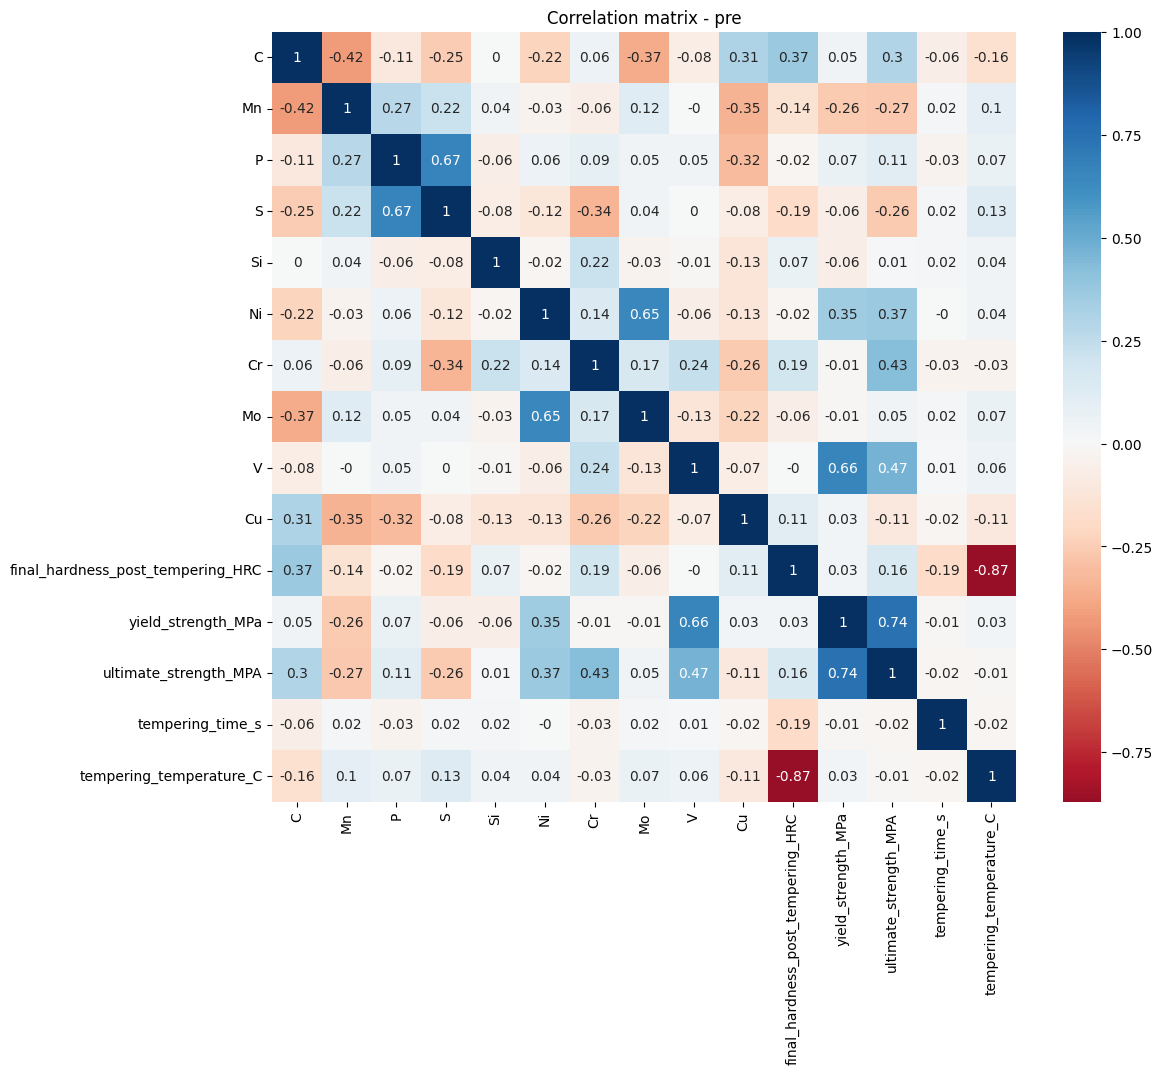

In [130]:
corr_data = pd.read_csv(f'{resources_path.parent}/all_cols_post_scrape.csv')

df_corr = corr_data.corr(numeric_only=True).round(2)

plt.figure(figsize=(12, 10))
plot_corr = sns.heatmap(df_corr, annot=True, cmap='RdBu', center=0)

plt.title('Correlation matrix - pre')
plt.savefig(f'{images_path.parent}/corr.png', bbox_inches='tight')

# Preprocess target values

All are converted to Celcius but several are very near together because theyw ere originally Farenheight.

eg 200 C is negligably near 204.4 C which equals 400 F.

55 C ranges were picked, as it makes 11 whole number bins from 100 to 705


## Bin tempering values by 55 C

38 C was considered (100 F) but some values were indistinct. 
55 C is a whole number value that results in a whole number of bins.

It results in 11 bins. 

This is the same number of bins when we bin tempering time <= 5 minutes

In [131]:
tempering_bins = range(155, 705, 55)
list(tempering_bins)

[155, 210, 265, 320, 375, 430, 485, 540, 595, 650]

In [132]:
labels = ['100', '200', '250', '300', '350', '400', '450', '500', '550', '600', '700']

In [133]:
#binned_temperting_tempC = 
tempering_tempC_binned = y_prepre['tempering_temperature_C'].cut(tempering_bins, labels=labels)
tempering_tempC_binned


tempering_temperature_C
cat
"""200"""
"""250"""
"""300"""
"""350"""
"""400"""
…
"""300"""
"""400"""
"""500"""


In [134]:
y = pl.DataFrame({'tempering_time_s_proc': y_prepre['tempering_time_s'],
    #'tempering_time_s_proc': tts_bin_string,
                   'tempering_temperature_C_proc': tempering_tempC_binned})
y

tempering_time_s_proc,tempering_temperature_C_proc
i64,cat
600,"""200"""
600,"""250"""
600,"""300"""
600,"""350"""
600,"""400"""
…,…
86400,"""300"""
86400,"""400"""
86400,"""500"""


# Preprocess data values

In [135]:
print(X_prepre.shape)
X_prepre.head(3)

(1286, 15)


steel_type,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC,yield_strength_MPa,ultimate_strength_MPA
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""AISI-SAE 1026""",0.25,0.79,0.012,0.026,0.11,0.0,0.0,0.0,0.0,0.0,0.0,50.6,415,490
"""AISI-SAE 1026""",0.25,0.79,0.012,0.026,0.11,0.0,0.0,0.0,0.0,0.0,0.0,48.3,415,490
"""AISI-SAE 1026""",0.25,0.79,0.012,0.026,0.11,0.0,0.0,0.0,0.0,0.0,0.0,43.7,415,490


# Encode and scale variables
Most columns are numeric and range from 0.0# to 1000 so scaling is necessary
steel names are categorical and would benefit from one-hot encoding.

## One hot encode steel types

Encoding chosen because this is a categorical for a given material and testing suite

In [136]:
to_scale = X_prepre.drop('steel_type')
check_onehot = X_prepre.select('steel_type')

In [137]:
print(len(check_onehot.unique()))
# correct duplicate name 
dict_rename.update({'AISI-SAE 1030': "AISI 1030"})
to_onehot = check_onehot['steel_type']\
    .replace(dict_rename)\
    .str.strip_chars()
[print(val) for val in to_onehot.unique()]
print(len(to_onehot.unique()))

30
AISI 6145
AISI-SAE 5140
AISI-SAE 1045
AISI-SAE 5160
AISI-SAE 4037
AISI 1074 Carbon Steel
AISI-SAE 1080
AISI-SAE 1038
AISI-SAE 1040
AISI-SAE 1035
AISI 1095
AISI 1049
AISI 52100
AISI-SAE 9254
AISI 4640
AISI-SAE 6150
AISI 1055
AISI 4047
AISI-SAE 4140
AISI-SAE 4027
AISI 1030
AISI-SAE 1042
AISI-SAE 1335
AISI-SAE 1050
AISI-SAE 1065
AISI 1090
AISI-SAE 1026
AISI-SAE 4340
28


In [138]:
to_onehot = pl.DataFrame(to_onehot)
to_onehot.shape

(1286, 1)

In [139]:
# create the transformers
ohe = OneHotEncoder(handle_unknown='ignore')

oh_transformed = ohe.fit_transform(to_onehot)

# get the transformed column names
ohe_names = ohe.get_feature_names_out()

# 4 stack exchange methods tried. Then I made this one up ¯\_(ツ)_/¯
# Combinated of recenly changed API and polars I think, no way to rename all columns like in pandas.
columns = [f'column_{x}' for x in range(0, 30)]
rename_dict = dict(zip(columns, ohe_names))

df_ohe_encoded = pl.DataFrame(oh_transformed.toarray()).rename(rename_dict)
df_ohe_encoded.tail(3)

steel_type_AISI 1030,steel_type_AISI 1049,steel_type_AISI 1055,steel_type_AISI 1074 Carbon Steel,steel_type_AISI 1090,steel_type_AISI 1095,steel_type_AISI 4047,steel_type_AISI 4640,steel_type_AISI 52100,steel_type_AISI 6145,steel_type_AISI-SAE 1026,steel_type_AISI-SAE 1035,steel_type_AISI-SAE 1038,steel_type_AISI-SAE 1040,steel_type_AISI-SAE 1042,steel_type_AISI-SAE 1045,steel_type_AISI-SAE 1050,steel_type_AISI-SAE 1065,steel_type_AISI-SAE 1080,steel_type_AISI-SAE 1335,steel_type_AISI-SAE 4027,steel_type_AISI-SAE 4037,steel_type_AISI-SAE 4140,steel_type_AISI-SAE 4340,steel_type_AISI-SAE 5140,steel_type_AISI-SAE 5160,steel_type_AISI-SAE 6150,steel_type_AISI-SAE 9254
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scale numerical columns 
This will ensure the small elemental composition values are not overshadowed by the large strength properties 

In [140]:
print(type(to_scale))
to_scale.tail(3)

<class 'polars.dataframe.frame.DataFrame'>


C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC,yield_strength_MPa,ultimate_strength_MPA
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,32.0,525,685
1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,23.0,525,685
1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,4.5,525,685


In [141]:
scaler = StandardScaler()

X_scaler = scaler.fit(to_scale)

scaled = scaler.transform(to_scale)

scaler_names = scaler.get_feature_names_out()
columns = [f'column_{x}' for x in range(0, 14)]
rename_dict = dict(zip(columns, scaler_names))

df_scaled = pl.DataFrame(scaled).rename(rename_dict)
df_scaled.tail(3)


C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC,yield_strength_MPa,ultimate_strength_MPA
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,0.0,-0.337311,-0.682819,0.188703,-0.105424
2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,0.0,-0.337311,-1.309217,0.188703,-0.105424
2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,0.0,-0.337311,-2.596813,0.188703,-0.105424


## Merge one hot encoded variables with scaled numeric variables

In [142]:
X = pl.concat([df_ohe_encoded, df_scaled], how='horizontal')
X

steel_type_AISI 1030,steel_type_AISI 1049,steel_type_AISI 1055,steel_type_AISI 1074 Carbon Steel,steel_type_AISI 1090,steel_type_AISI 1095,steel_type_AISI 4047,steel_type_AISI 4640,steel_type_AISI 52100,steel_type_AISI 6145,steel_type_AISI-SAE 1026,steel_type_AISI-SAE 1035,steel_type_AISI-SAE 1038,steel_type_AISI-SAE 1040,steel_type_AISI-SAE 1042,steel_type_AISI-SAE 1045,steel_type_AISI-SAE 1050,steel_type_AISI-SAE 1065,steel_type_AISI-SAE 1080,steel_type_AISI-SAE 1335,steel_type_AISI-SAE 4027,steel_type_AISI-SAE 4037,steel_type_AISI-SAE 4140,steel_type_AISI-SAE 4340,steel_type_AISI-SAE 5140,steel_type_AISI-SAE 5160,steel_type_AISI-SAE 6150,steel_type_AISI-SAE 9254,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC,yield_strength_MPa,ultimate_strength_MPA
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,0.0,-0.337311,0.611736,-0.342255,-1.009596
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,0.0,-0.337311,0.451657,-0.342255,-1.009596
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,0.0,-0.337311,0.131498,-0.342255,-1.009596
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,0.0,-0.337311,-0.091221,-0.342255,-1.009596
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,0.0,-0.337311,-0.31394,-0.342255,-1.009596
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,0.0,-0.337311,0.604776,0.188703,-0.105424
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,0.0,-0.337311,0.013178,0.188703,-0.105424
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,0.0,-0.337311,-0.682819,0.188703,-0.105424


In [143]:
X.write_csv(f"{resources_path}/X_nopreproc.csv")
y.write_csv(f"{resources_path}/y_nopreproc.csv")


## Modelling for data preprocess

PCA modelling used to reduce X dimensions from 44 to 12 maintaining 95.7% of the explained variance.

KBinsDiscretizer used to bin imbalanced Y target. 15 bins, where half have less than 5 support reduced to 5 similarly supported bins

### PCA analysis

Introduction of two strength metrics certainly introduced multcolinearity, with eachother and with the elemental composision, some of whicha re indicators of strength.

PCA analysis will be done to alleiviate these factors.

In [144]:
X = pl.read_csv(f"{resources_path}/X_nopreproc.csv")

In [145]:
pca_explained_sum = {'x': [], 'pca_explained_var': []}
pca_explained_min = {'x': [], 'pca_explained_min_component': []}
for x in range(3,30):
    pca = PCA(n_components=x ,random_state=random_state)

    pca.fit(X)

    pca_explained_sum['x'].append(x)
    sum_explained = np.sum(pca.explained_variance_ratio_)
    pca_explained_sum['pca_explained_var'].append(sum_explained)

    pca_explained_min['x'].append(x)
    min_explained = np.min(pca.explained_variance_ratio_)
    pca_explained_min['pca_explained_min_component'].append(min_explained)

In [146]:
df_pca_explained = pl.DataFrame(pca_explained_sum)

### PCA component number determination

In [147]:
alt.Chart(df_pca_explained,
          title= "Total Explained Variance vs Number of PCA Features").mark_line().encode(
    alt.X('x:Q').title("PCA X"),
    alt.Y('pca_explained_var:Q')\
        .scale(domain=(0.5,1))\
            .title("Total explained variance")
)

alt.Chart(...)

### Value of increasing PCA components decreases between 10 and 15

In [148]:
df_pca_explained_min = pl.DataFrame(pca_explained_min)
df_pca_explained_min.filter(pl.col('x').le(15) & pl.col('x').ge(10))

x,pca_explained_min_component
i64,f64
10,0.027068
11,0.016536
12,0.012252
13,0.00728
14,0.003415
15,0.003222


### PCA component number 12 selected
Component 13 has half the explained ratio contribution as component 12, and component 13 is below 1% contribution

12 components has explains 95.7% of the variance.

In [149]:
df_pca_explained.filter(pl.col("x").eq(12))

x,pca_explained_var
i64,f64
12,0.958984


In [150]:
pca = PCA(n_components= 12, random_state=random_state)

pca.fit(X)

X_pca = pca.transform(X)

df_pca = pl.DataFrame(X_pca)
df_pca.head(3)

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-1.320436,0.433031,0.152744,-0.280106,-0.553453,-0.44246,0.789612,-0.116024,-1.126339,-0.650522,0.107193,0.362395
-1.352601,0.406635,0.167524,-0.322172,-0.622424,-0.421108,0.677043,-0.122864,-1.069579,-0.628965,0.113458,0.349196
-1.416932,0.353842,0.197083,-0.406302,-0.760366,-0.378402,0.451906,-0.136544,-0.956058,-0.585849,0.125988,0.3228


In [151]:
df_pca.describe()

statistic,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.3813e-17,-8.0116e-17,-1.9338e-17,-8.8403e-17,5.5252e-17,-6.9756e-17,2.7626e-17,8.2878e-18,9.3929e-17,-1.2432e-17,-4.4202e-17,-8.8403e-17
"""std""",1.671878,1.574001,1.326873,1.227762,1.111202,0.940244,0.877177,0.810873,0.726039,0.61486,0.480573,0.413657
"""min""",-3.160272,-3.06014,-2.519346,-2.932731,-3.087486,-1.308532,-3.902866,-1.63648,-1.578573,-1.071457,-0.958913,-1.076012
"""25%""",-1.250181,-0.982207,-0.686134,-0.726365,-0.712909,-0.511157,-0.591495,-0.491043,-0.44238,-0.453306,-0.291369,-0.349439
"""50%""",-0.08415,-0.039102,-0.084792,-0.100102,0.038288,-0.116496,0.117907,-0.01247,-0.040194,-0.08842,-0.005293,0.090399
"""75%""",0.67165,0.967478,0.507161,0.808819,0.655451,0.288545,0.586282,0.532562,0.286874,0.362959,0.234679,0.310155
"""max""",4.637292,3.551286,4.27113,3.572446,4.371646,4.388313,2.409663,1.558366,2.57386,1.741962,1.042306,0.715972


## Correlation heatmap of PCA features

In [152]:
df_pca.to_pandas()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
0,-1.320436,0.433031,0.152744,-0.280106,-0.553453,-0.442460,0.789612,-0.116024,-1.126339,-0.650522,0.107193,0.362395
1,-1.352601,0.406635,0.167524,-0.322172,-0.622424,-0.421108,0.677043,-0.122864,-1.069579,-0.628965,0.113458,0.349196
2,-1.416932,0.353842,0.197083,-0.406302,-0.760366,-0.378402,0.451906,-0.136544,-0.956058,-0.585849,0.125988,0.322800
3,-1.461684,0.317117,0.217646,-0.464828,-0.856326,-0.348694,0.295289,-0.146061,-0.877087,-0.555856,0.134704,0.304438
4,-1.506436,0.280391,0.238210,-0.523354,-0.952285,-0.318986,0.138672,-0.155577,-0.798116,-0.525863,0.143420,0.286075
...,...,...,...,...,...,...,...,...,...,...,...,...
1281,0.853454,2.098495,0.374081,-0.022713,0.935600,-0.437547,-0.240436,-1.418268,-0.323090,1.291345,0.741496,-0.137127
1282,0.734582,2.000943,0.428702,-0.178172,0.680707,-0.358634,-0.656450,-1.443546,-0.113324,1.371015,0.764649,-0.185903
1283,0.594733,1.886176,0.492962,-0.361065,0.380833,-0.265797,-1.145879,-1.473285,0.133460,1.464744,0.791887,-0.243286
1284,0.468868,1.782885,0.550796,-0.525669,0.110947,-0.182242,-1.586364,-1.500050,0.355566,1.549100,0.816401,-0.294931


In [153]:

import matplotlib.cm as cm
cm.ScalarMappable(cmap='RdBu').set_clim(vmin=-1, vmax=1)

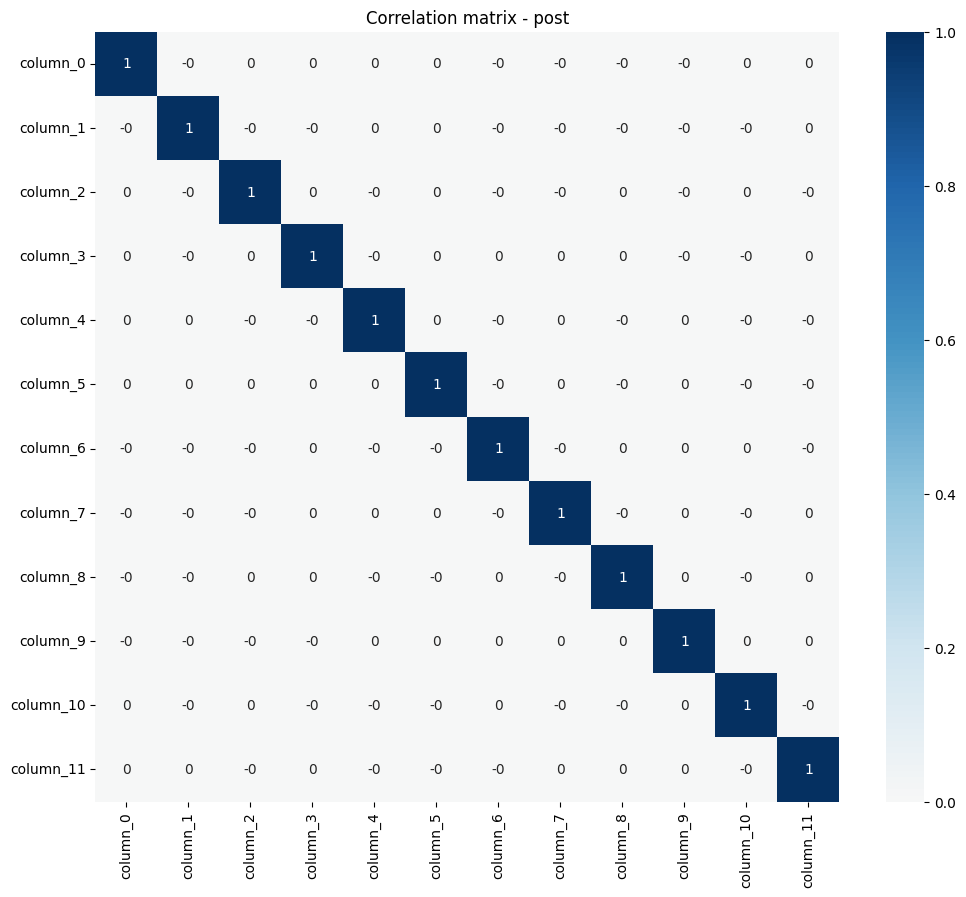

In [154]:

df_corr_pca = df_pca.to_pandas().corr(numeric_only=True).round(2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_corr_pca, annot=True, cmap='RdBu', center=0, ax=ax)


ax.set_title('Correlation matrix - post')
plt.show()
fig.savefig(f'{images_path}/corr_pca.png', bbox_inches='tight')

### Expected result of PCA. Absolutely no colinearity

## Check data balance before train-test-split

In [155]:
y = pl.read_csv(f"{resources_path}/y_nopreproc.csv", schema=pl.Schema({"tempering_time_s_proc":pl.String,
                                                             "tempering_temperature_C_proc":pl.String}))
y.columns

['tempering_time_s_proc', 'tempering_temperature_C_proc']

In [156]:
for col in ['tempering_time_s_proc', 'tempering_temperature_C_proc']:
    temp = y.select(pl.col(col)\
                    .value_counts(sort=True, name='n'))\
                        .unnest(col)\
                            .with_columns(pl.col(col).cast(pl.Int32))
    print(temp)
 


shape: (15, 2)
┌───────────────────────┬─────┐
│ tempering_time_s_proc ┆ n   │
│ ---                   ┆ --- │
│ i32                   ┆ u32 │
╞═══════════════════════╪═════╡
│ 3600                  ┆ 237 │
│ 86400                 ┆ 206 │
│ 14400                 ┆ 130 │
│ 900                   ┆ 120 │
│ 600                   ┆ 108 │
│ …                     ┆ …   │
│ 57600                 ┆ 30  │
│ 115200                ┆ 30  │
│ 40                    ┆ 24  │
│ 120                   ┆ 24  │
│ 300                   ┆ 24  │
└───────────────────────┴─────┘
shape: (11, 2)
┌──────────────────────────────┬─────┐
│ tempering_temperature_C_proc ┆ n   │
│ ---                          ┆ --- │
│ i32                          ┆ u32 │
╞══════════════════════════════╪═════╡
│ 400                          ┆ 170 │
│ 500                          ┆ 167 │
│ 600                          ┆ 164 │
│ 300                          ┆ 145 │
│ 200                          ┆ 141 │
│ …                            ┆ …  

## Unbalanced targets needs processing

Some classifications has 200+ support but many have 50 or less in both metrics. (above)

Binning through an algorithm will be used to allieviate this

Before binning the f1 score scores were exceptionally low and support scores were very imbalanced. 

![before_balancing.png](images/multiout/before_balancing.png)
![after_balancing.png](images/multiout/after_balancing.png)

In [157]:
# https://imbalanced-learn.org/stable/common_pitfalls.html
t_temp_proc = y.select('tempering_temperature_C_proc')
y

tempering_time_s_proc,tempering_temperature_C_proc
str,str
"""600""","""200"""
"""600""","""250"""
"""600""","""300"""
"""600""","""350"""
"""600""","""400"""
…,…
"""86400""","""300"""
"""86400""","""400"""
"""86400""","""500"""


In [158]:
# vshort short med long vlong?
# Kbinsdescritizer
# [0-10min),[10min-60min), [60min-150min),[2.5h-8h), [8h+)   
y = y.with_columns(pl.col('tempering_time_s_proc').cast(pl.Int32))
bin_this = y['tempering_time_s_proc']

In [159]:
to_bin = bin_this.reshape((-1,1))
binner = KBinsDiscretizer(n_bins = 5, encode='ordinal', strategy='quantile')
binner.fit(to_bin)
binned = binner.transform(to_bin)
bin_labels = []

edges = binner.bin_edges_[0]
for i in range(len(edges)-1):
    # Keep numeric label, use axis labelling to denote this, not index labelling
    # time units are tempered for less than x minutes
    # label = f"< {edges [i + 1] / 60} min"
    label = edges [i + 1] / 60
    bin_labels.append(int(label))
bin_labels


[5, 60, 150, 960, 1920]

In [160]:
dict_label_bins = dict(zip(['0.0','1.0','2.0','3.0','4.0'], bin_labels))
dict_label_bins

{'0.0': 5, '1.0': 60, '2.0': 150, '3.0': 960, '4.0': 1920}

In [161]:
to_label = pl.DataFrame(binned).with_columns(pl.col('column_0')\
                                             .alias('tempering_time_min_binned'))\
                                                .select('tempering_time_min_binned')
y_time_binned = to_label.with_columns(pl.col('tempering_time_min_binned')\
                                      .cast(pl.String)\
                                       .replace(dict_label_bins))

In [162]:
y = pl.concat([y_time_binned, t_temp_proc], how='horizontal')
y = y.with_columns(pl.col('tempering_time_min_binned').cast(pl.Int32),
               pl.col('tempering_temperature_C_proc').cast(pl.Int32))

In [163]:
time = y['tempering_time_min_binned'].to_numpy().reshape(-1, 1)
enc_ord_time = OrdinalEncoder()
enc_ord_time.fit(time)
encd_time = enc_ord_time.transform(time)
encd_time = pl.Series(encd_time).arr.get(0)

In [164]:
temp = y['tempering_temperature_C_proc'].to_numpy().reshape(-1, 1)
enc_ord_temp = OrdinalEncoder()
enc_ord_temp.fit(temp)
encd_temp = enc_ord_temp.transform(temp)
encd_temp = pl.Series(encd_temp).arr.get(0)

In [165]:
y_enc = pl.DataFrame({"time":encd_time, "temp":encd_temp})
y_enc

time,temp
f64,f64
1.0,1.0
1.0,2.0
1.0,3.0
1.0,4.0
1.0,5.0
…,…
4.0,3.0
4.0,5.0
4.0,7.0


In [166]:
df_pca.write_csv(f'{resources_path}/df_X.csv')
y_enc.write_csv(f'{resources_path}/df_y.csv')


# Modelling

In [167]:
X = pl.read_csv(f'{resources_path}/df_X.csv')
y = pl.read_csv(f'{resources_path}/df_y.csv',   
                schema={'tempering_time_min_binned': pl.Float32, 
                        'tempering_temperature_C_proc' : pl.Float32})
# Polars does not always work well with Keras
X = X.to_numpy()
y = y.to_numpy()

## Test train split

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=random_state, 
                                                    stratify=y)

## Random ExtraTreesClassifier Model

Chosen as a multiclass multilabel classifier that works by default, without the use of MultiOutputClassifier.

### This naive model does not perform well.

Target Feature|Accuracy|f1 Score
---|---|---
TimeTarget|15.5%|29.7%
TempTarget|31.4%|15.9%

In [169]:
et_classifier = ExtraTreesClassifier(n_estimators=10, 
                                      criterion='entropy',
                                      random_state=random_state)

et_classifier.fit(X_train, y_train)


ExtraTreesClassifier(criterion='entropy', n_estimators=10,
                     random_state=2112250415)

In [170]:
y_pred = et_classifier.predict(X_test)


In [171]:
labels = []
target_prefixes = ["ttime_", "ttemp_"]
target_units = ['_min', '_C']

for i in range(y_test.shape[1]):
    prefixed = list(map(lambda x: f"{target_prefixes[i]}{x}{target_units[i]}", et_classifier.classes_[i]))
    labels.append(prefixed)

In [172]:
classification_reports = []
for i in range(y_test.shape[1]):
    cr = classification_report(y_test[:, i], y_pred[:, i],  output_dict=True)#target_names=labels[i],)
    classification_reports.append(cr)

In [173]:
# polars does not parse the dicts correctly
cr_rf_ttime = pd.DataFrame(classification_reports[0]).transpose()
cr_rf_ttemp = pd.DataFrame(classification_reports[1]).transpose()

def fix_classification_report(pd_df):
    pl_df = pl.DataFrame(pd_df.reset_index())\
        .filter(pl.col('index').str.contains('avg|acc').not_())\
        .with_columns(pl.col('index').cast(pl.Float32))\
        .sort('index', descending=False)
    return pl_df

pl_cr_rf_ttime = fix_classification_report(cr_rf_ttime)

pl_cr_rf_ttemp = fix_classification_report(cr_rf_ttemp)

# display 2 DF inline https://softhints.com/display-two-pandas-dataframes-side-by-side-jupyter-notebook/
cr_rf_ttime_styler = cr_rf_ttime.style.set_table_attributes("style='display:inline'")\
    .set_caption('Tempering Time')
cr_rf_ttemp_styler = cr_rf_ttemp.style.set_table_attributes("style='display:inline'")\
    .set_caption('Tempering Temperature')

space = "\xa0" * 10
display_html(cr_rf_ttemp_styler._repr_html_() + space + cr_rf_ttime_styler._repr_html_(), raw=True)

,precision,recall,f1-score,support
0.0,0.580645,0.620690,0.600000,29.000000
1.0,0.575758,0.527778,0.550725,36.000000
2.0,0.178571,0.178571,0.178571,28.000000
3.0,0.461538,0.500000,0.480000,36.000000
4.0,0.333333,0.250000,0.285714,12.000000
5.0,0.384615,0.348837,0.365854,43.000000
6.0,0.058824,0.083333,0.068966,12.000000
7.0,0.274510,0.333333,0.301075,42.000000
8.0,0.210526,0.200000,0.205128,20.000000
9.0,0.333333,0.350000,0.341463,40.000000


In [174]:

rf_cr_ttemp_supp_plot = alt.Chart(pl_cr_rf_ttemp)\
    .mark_bar().encode(
        alt.X('index:O').title('Tempering Temperature (C)'),
        alt.Y('support'),
        alt.Color('f1-score')
        )

rf_cr_ttime_supp_plot = alt.Chart(pl_cr_rf_ttime)\
    .mark_bar().encode(
        alt.X('index:O').title('Tempering Time (< min)'),
        alt.Y('support'),
        alt.Color('f1-score')
        )
rf_cr_ttemp_supp_plot

alt.concat(rf_cr_ttemp_supp_plot, rf_cr_ttime_supp_plot).properties(title='After Balancing Tempering Time')

alt.ConcatChart(...)

## ExtraTreesClassifier has very poor accuracy

16% for tempering time and 31% for tempering temperature

Combined accuracy of 26.1%

Moving to a Deep Neural Network model to try and improve performance. 

# Deep Neural Network Model

In [175]:
df_y_test = pl.DataFrame(y_test).with_columns(pl.col('column_0').alias('time'),
                                              pl.col('column_1').alias('temp'))\
                                              .select(['time','temp'])
df_y_test.tail(3)

time,temp
f32,f32
3.0,0.0
3.0,2.0
2.0,9.0


In [176]:
dim_input = X_test.shape[1]
dim_output_time = df_y_test['time'].unique().shape[0]
dim_output_temp = df_y_test['temp'].unique().shape[0]
print("Xdim", dim_input,"| ytimedim", dim_output_time, "| ytempdim", dim_output_temp)
# dim_output = y_test.shape[0]
# print("Xdim", dim_input,"| ydim", dim_output)

Xdim 12 | ytimedim 5 | ytempdim 11


In [177]:
# https://machinelearningmastery.com/multi-label-classification-with-deep-learning/

# input
inputs = Input(shape=(dim_input,))
# fork model to predict times
db1 = Dense(512, activation='relu')(inputs)
db1 = Dense(128, activation='relu')(db1)
db1 = Dense(32, activation='relu')(db1)
# fork model to predict tempereatures
db2 = Dense(512, activation='relu')(inputs)
db2 = Dense(128, activation='relu')(db2)
db2 = Dense(32, activation='relu')(db2)
# Output layers for each label
output1 = Dense(dim_output_time, activation='sigmoid', name='TTime_out')(db1)
output2 = Dense(dim_output_temp, activation='sigmoid', name='TTemp_out')(db2)

nn_model = Model(inputs=inputs, outputs=[output1, output2])

nn_model.compile(optimizer='adam',
                 loss={'TTime_out': 'sparse_categorical_crossentropy', 
                       'TTemp_out': 'sparse_categorical_crossentropy'},
                 metrics={'TTime_out': 'sparse_categorical_accuracy', 
                       'TTemp_out': 'sparse_categorical_accuracy'})

nn_model.fit(x=X_train, y=[y_train[:,0], 
                           y_train[:,1]], 
                        verbose=0, 
                        epochs=100,
                        validation_split=0.2)


In [180]:
nn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │      6,656 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │      6,656 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      4,128 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      4,128 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TTime_out (Dense)   │ (None, 5)         │        165 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TTemp_out (Dense)   │ (None, 11)        │        363 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,274 (1.76 MB)

 Trainable params: 153,424 (599.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,850 (1.17 MB)

## Evaluate NN model

Fit and model done 5 times to get stability from the accuracies generated per model.

In [181]:
def make_pred(model, y_test):
    # Make the softmax prediction
    y_pred = model.predict(X_test)
    # Collapse softmax into a pair of columns, with ordinal encoded values
    pred_time = np.argmax(y_pred[0], axis=1)
    pred_temp = np.argmax(y_pred[1], axis=1)
    # Combine into (,2) rank to compare with y_test 
    y_pred = np.array(list(zip(pred_time,pred_temp)))
    return y_pred

In [182]:
def eval_2headed_model(model, y_test):
    #make and process the model prediction into the same form vs y_test
    y_pred = make_pred(model, y_test)
    
    accuracies = []
    for i in range(y_test.shape[1]):
        acc = accuracy_score(y_test[:, i],y_pred[:, i])
        accuracies.append(acc)

    return accuracies[0], accuracies[1], np.mean(accuracies)

In [183]:
def eval_avg_5_times(model, y_test, n=5):
    timeAccs = []
    tempAccs = []
    avgAccs = []

    x = 0
    while x < n:
        timeAcc, tempAcc, avgAcc = eval_2headed_model(model, y_test)
        timeAccs.append(timeAcc)
        tempAccs.append(tempAcc)
        avgAccs.append(avgAcc)
        x += 1

    print("timeAcc:", round(np.mean(timeAccs),3), "tempAcc:", round(np.mean(tempAccs),3))
    print("Average Accuracy:", round(np.mean(avgAccs),3))
    


In [184]:
eval_avg_5_times(nn_model, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
timeAcc: 0.255 tempAcc: 0.447
Average Accuracy: 0.351


# Build a Tuner

In [185]:
def create_hp_model(hp):
    #Activation for all hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    # input
    inputs = Input(shape=(dim_input,))
    x = inputs
    
    # fork model to predict times
    x0 = Dense(units=hp.Int('time_units1',
                             min_value=32,
                             max_value=512,
                             sampling='linear'), 
                             activation=activation)(x)
    x0 = Dense(units=hp.Int('time_units2',
                             min_value=32,
                             max_value=512,
                             sampling='linear'), 
                             activation=activation)(x0)
    x0 = Dense(units=hp.Int('time_units3',
                             min_value=16,
                             max_value=256,
                             sampling='linear'), 
                             activation=activation)(x0)
    x0 = Dense(units=hp.Int('time_units4',
                             min_value=4,
                             max_value=128,
                             sampling='linear'), 
                             activation=activation)(x0)
    
    # fork model to predict temp
    x1 = Dense(units=hp.Int('temp_units1',
                             min_value=32,
                             max_value=256,
                             sampling='linear'), 
                             activation=activation)(x)
    x1 = Dense(units=hp.Int('temp_units2',
                             min_value=32,
                             max_value=128,
                             sampling='linear'), 
                             activation=activation)(x1)
    x1 = Dense(units=hp.Int('temp_units3',
                             min_value=4,
                             max_value=32,
                             sampling='linear'), 
                             activation=activation)(x1)
    
    # Output layers for each label
    output0 = Dense(dim_output_time, activation='softmax', name='TTime_out')(x0)
    output1 = Dense(dim_output_temp, activation='softmax', name='TTemp_out')(x1)

    nn_model = Model(inputs=inputs, outputs=[output0, output1])

    nn_model.compile(optimizer='sgd',
                     loss={'TTime_out': 'sparse_categorical_crossentropy', 
                           'TTemp_out': 'sparse_categorical_crossentropy'},
                     loss_weights={'TTime_out': 1.0, 
                           'TTemp_out': 1.0},
                     metrics=["accuracy","accuracy"])
    
    return nn_model

In [186]:
tuner = kt.Hyperband(
    create_hp_model,
    objective=["val_loss","val_loss"],
    max_epochs=20,
    factor=5,
    hyperband_iterations=2,
    project_name='multiout_DNN',
    executions_per_trial=5)


Reloading Tuner from ./multiout_DNN/tuner0.json


In [187]:
tuner.search(x=X_train, 
             y=[y_train[:,0], 
                y_train[:,1]],
             epochs=250,
             validation_data=(X_test,[y_test[:,0], 
                                      y_test[:,1]]))

In [188]:
best_model = tuner.get_best_models(1)[0]

In [189]:
best_model.fit(x=X_train, 
               y=[y_train[:,0], 
                  y_train[:,1]], 
               verbose=0,
               epochs=3)

In [190]:
tuner.get_best_hyperparameters(1)[0].values

{'activation': 'tanh',
 'time_units1': 501,
 'time_units2': 500,
 'time_units3': 50,
 'time_units4': 8,
 'temp_units1': 256,
 'temp_units2': 82,
 'temp_units3': 18,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0016'}

In [191]:
eval_avg_5_times(best_model, y_test, 5)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
timeAcc: 0.311 tempAcc: 0.351
Average Accuracy: 0.331


# Two headed Model Optimization

property | Model Structure 1 | Model Structure 2 | Model Structure 3 | Structure1 SDG
---|---|---|---|---
timeAcc| 0.307 | 0.258 |0.252 | 0.28
tempAcc| 0.481 | 0.407 | 0.466 |  0.373
Weighted Average Accuracy| 0.394 | 0.332 | 0.359 | 3.26
activation  | 'relu' | 'relu' | 'relu' | 'relu' 
time_units1 | 487 | 96 | 128 |510
time_units2 | 143 | -- | -- | 175
time_units3 | 246 | 16 | 160 | 189
time_units4 | 51 | 52 | 92 | 31
temp_units1 | 172 | 160 | 128 | 243
temp_units2 | 84 | -- | 64 | 116
temp_units3 | 29 | 12 | 20 | 32
tuner/epochs |  20 | 20 | 20 | 20

---

Model Structure 1
```
Input-------L1---L2---L3---L4---TimeOutput
        |
        ----L1---L2---L3---TempOutput
```  
---

Model Structure 2
```
Input-------L1---L3---L4---TimeOutput
        |
        ----L1---L3---TempOutput
```  

Model Structure 3
```
Input-------L1---L3---L4---TimeOutput
        |
        ----L1---L2---L3---TempOutput
```  
---
     

# Chosen Model Structure 1, optimizing optimizer

In [192]:
def create_model(optimizer='adam'):

    # input
    inputs = Input(shape=(dim_input,))
    x = inputs
    
    # fork model to predict times
    x0 = Dense(units=487, activation='relu')(x)
    x0 = Dense(units=143, activation='relu')(x0)
    x0 = Dense(units=246, activation='relu')(x0)
    x0 = Dense(units=51, activation='relu')(x0)
    
    # fork model to predict temp
    x1 = Dense(units=172, activation='relu')(x)
    x1 = Dense(units=84, activation='relu')(x1)
    x1 = Dense(units=29, activation='relu')(x1)
    
    # Output layers for each label
    output0 = Dense(dim_output_time, activation='softmax', name='TTime_out')(x0)
    output1 = Dense(dim_output_temp, activation='softmax', name='TTemp_out')(x1)

    nn_model = Model(inputs=inputs, outputs=[output0, output1])

    nn_model.compile(optimizer=optimizer,
                     loss={'TTime_out': 'sparse_categorical_crossentropy', 
                           'TTemp_out': 'sparse_categorical_crossentropy'},
                     loss_weights={'TTime_out': 1.0, 
                           'TTemp_out': 1.0},
                     metrics=["accuracy","accuracy"])
    
    return nn_model

model = create_model()
model.fit(x=X_train, 
          y=[y_train[:,0], 
             y_train[:,1]], 
          verbose=0,
          epochs=150)
eval_avg_5_times(model, y_test, n=15)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
timeAcc: 0.23 tempAcc: 0.506
Average Accuracy: 0.368


In [193]:
opts = [name.lower() for name in ["Adadelta", 
                                        "Adafactor", 
                                        "Adagrad", 
                                        "Adam", 
                                        "AdamW", 
                                        "Adamax", 
                                        "Ftrl", 
                                        "Lion", 
                                        "Nadam", 
                                        "RMSprop", 
                                        "SGD"]]

In [194]:
for opt in opts:
    model = create_model(opt)
    model.fit(x=X_train, 
            y=[y_train[:,0], 
                y_train[:,1]],
            verbose=0,
            epochs=150,
            validation_split=0.2)
    print("Optimizer:",opt)
    eval_avg_5_times(model, y_test, n=15)
    print('\n')

Optimizer: adadelta
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
timeAcc: 0.245 tempAcc: 0.124
Average Accuracy: 0.185


Optimizer: adafactor
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
11/

optimizer results | averaged accuracy
---|---
adam|0.334
adamw|0.323
adamax|0.374
nadam|0.314
sgd|0.354
adadelta|0.154
adafactor|0.314
adagrad|0.293
ftrl|0.160
lion|0.359
rmsprop|0.337



## Epoch optimization

In [195]:
model = create_model(optimizer='sgd')
fit = model.fit(x=X_train, 
         y=[y_train[:,0], 
            y_train[:,1]], 
         verbose=0,
         epochs=250,
         validation_split=0.2)
eval_avg_5_times(model, y_test)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
timeAcc: 0.255 tempAcc: 0.475
Average Accuracy: 0.365


In [196]:
history_df = pl.DataFrame(fit.history)
history_df = history_df.with_row_index()
history_df.head(3)


index,TTemp_out_accuracy,TTemp_out_loss,TTime_out_accuracy,TTime_out_loss,loss,val_TTemp_out_accuracy,val_TTemp_out_loss,val_TTime_out_accuracy,val_TTime_out_loss,val_loss
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.094682,2.370039,0.197147,1.615507,3.98154,0.129534,2.330581,0.222798,1.599024,3.938419
1,0.124514,2.344878,0.233463,1.599056,3.943725,0.098446,2.3269,0.310881,1.577266,3.914546
2,0.140078,2.321762,0.303502,1.585706,3.910271,0.098446,2.323186,0.321244,1.557413,3.893346


In [197]:
df_loss = history_df.select(['index', 'TTemp_out_loss', 'TTime_out_loss', 'loss'])
df_loss = df_loss.rename({'TTemp_out_loss':'Tempering Temperature Loss',
                'TTime_out_loss':'Tempering Time Loss',
                'loss':'Loss'})

In [198]:
chart_loss = alt.Chart(df_loss).mark_line().encode(
    alt.X('index').title('Epochs'),
    alt.Y(alt.repeat('layer'), type='quantitative').\
        title('Loss elements'),
    color = alt.datum(alt.repeat('layer'))
).repeat(
    layer = ['Tempering Temperature Loss', 'Tempering Time Loss', 'Loss']
).properties(title="Loss and Loss Elements by Epoch")
chart_loss.save(f"{images_path}/DNN_loss.png")
chart_loss

alt.RepeatChart(...)

In [199]:

df_acc = history_df.select(['index', 'TTemp_out_accuracy', 'TTime_out_accuracy'])
df_acc = df_acc.rename({'TTemp_out_accuracy':'Tempering Temperature Acc',
                'TTime_out_accuracy':'Tempering Time Acc'})

In [200]:
chart_acc = alt.Chart(df_acc).mark_line().encode(
    alt.X('index').title('Epochs'),
    alt.Y(alt.repeat('layer'), type='quantitative').\
        title('Accuracies'),
    color = alt.datum(alt.repeat('layer'))
).repeat(
    layer = ['Tempering Temperature Acc', 'Tempering Time Acc']
).properties(title="Accuracies by Epoch")
chart_acc.save(f"{images_path}/DNN_acc.png")
chart_acc

alt.RepeatChart(...)

# Model Selected, performance is poor

In [201]:
model = create_model(optimizer='sgd')
model.fit(x=X_train, 
        y=[y_train[:,0], 
            y_train[:,1]], 
        verbose=0,
        epochs=100,
        validation_split=0.2)
eval_avg_5_times(model, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
timeAcc: 0.307 tempAcc: 0.441
Average Accuracy: 0.374


# Next steps for multioutput 

The information contained in the dataset is insufficent for this modelling. It is possible that training two models, where the other target is a feature would provide better results than a singular dual headed model.

This still may not provide enough information fo the models to perform as well as desired however. Collecting more rows from other scientific reviews would be the obvious next step.

---

# Transition to regression single target

Target final hardness, include tempering process as data

In [202]:
resources_path = pathlib.PurePath(pathlib.PurePath(cwd), 'resources', 'pred_hardness')

images_path = pathlib.PurePath(pathlib.PurePath(cwd), 'images', 'pred_hardness')

In [203]:
data = pl.read_csv(f'{resources_path.parent}/all_cols_post_scrape.csv')
print(data.shape)
data.tail(3)

(1286, 16)


steel_type,C,Mn,P,S,Si,Ni,Cr,Mo,V,Cu,final_hardness_post_tempering_HRC,yield_strength_MPa,ultimate_strength_MPA,tempering_time_s,tempering_temperature_C
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64
"""1,15%C - plain carbon steel""",1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,32.0,525,685,86400,500.0
"""1,15%C - plain carbon steel""",1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,23.0,525,685,86400,600.0
"""1,15%C - plain carbon steel""",1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,4.5,525,685,86400,700.0


# Select columns that have relevant data for the analysis

Exclude:
* Source data - does not provide information about the problem
* initial hardness - very incomplete data and no accurate way to fill it
* searchable -  contains more information than searchable, but is likely relipcated in elemental
  * Searchable contains fewer values, this grouping was used to scrape the strength values and contains no additional information
  * steel_type contains steel denotation from the papers. The informationa in this column is replicated in the elemental composition columns
  * PCA will handle this


# Preprocessing the data for machine learning

In [204]:
target_columns = ['final_hardness_post_tempering_HRC']

X_prepre = data.drop(target_columns)

y_prepre = data.select(target_columns)

In [205]:
y_prepre.head(3)

final_hardness_post_tempering_HRC
f64
50.6
48.3
43.7


In [206]:
y_prepre.describe()

statistic,final_hardness_post_tempering_HRC
str,f64
"""count""",1286.0
"""null_count""",0.0
"""mean""",41.810653
"""std""",14.373455
"""min""",0.9
"""25%""",32.5
"""50%""",43.6
"""75%""",52.3
"""max""",68.5


# Preprocess target values

Target values are continuious.

Scaling provides a approximately 1% improvement of R-squared values

Creating a y-scaler will allow me to inverse scale the model results 

In [207]:
y_scaler = StandardScaler()

y_scaler.fit(y_prepre)

y = y_scaler.transform(y_prepre)

# Preprocess data values

In [208]:
print(X_prepre.shape)
X_prepre.head(3)

(1286, 15)


steel_type,C,Mn,P,S,Si,Ni,Cr,Mo,V,Cu,yield_strength_MPa,ultimate_strength_MPA,tempering_time_s,tempering_temperature_C
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64
"""AISI-SAE 1026""",0.25,0.79,0.012,0.026,0.11,0.0,0.0,0.0,0.0,0.0,415,490,600,204.4
"""AISI-SAE 1026""",0.25,0.79,0.012,0.026,0.11,0.0,0.0,0.0,0.0,0.0,415,490,600,260.0
"""AISI-SAE 1026""",0.25,0.79,0.012,0.026,0.11,0.0,0.0,0.0,0.0,0.0,415,490,600,315.6


# Encode and scale variables

Most columns are numeric and range from 0.0# to 1000 so scaling is necessary

Steel names are categorical and would benefit from one-hot encoding.

A pipeline would be best here, to allow introduction of new rows, but this is an exploratory project.


In [209]:
to_scale = X_prepre.drop('steel_type')
check_onehot = X_prepre.select('steel_type')

## One hot encode steel types

Encoding chosen because this is a categorical for a given material and testing suite

### Unify steel names so there is only 1 column per steel code

In [210]:
print(len(check_onehot.unique()))
# correct duplicate name 
dict_rename.update({'AISI-SAE 1030': "AISI 1030"})
to_onehot = check_onehot['steel_type']\
    .replace(dict_rename)\
    .str.strip_chars()
[print(val) for val in to_onehot.unique()]
print(len(to_onehot.unique()))

30
AISI-SAE 1080
AISI 1090
AISI-SAE 1045
AISI 1055
AISI-SAE 1042
AISI-SAE 1040
AISI-SAE 1335
AISI-SAE 4037
AISI-SAE 5160
AISI 52100
AISI 6145
AISI-SAE 1050
AISI-SAE 4027
AISI-SAE 5140
AISI 1049
AISI 4640
AISI-SAE 1065
AISI-SAE 4340
AISI 1074 Carbon Steel
AISI-SAE 4140
AISI-SAE 1038
AISI-SAE 1035
AISI 1095
AISI 1030
AISI-SAE 6150
AISI-SAE 9254
AISI 4047
AISI-SAE 1026
28


In [211]:
to_onehot = pl.DataFrame(to_onehot)
to_onehot.shape

(1286, 1)

In [212]:
# create the transformers
ohe = OneHotEncoder(handle_unknown='ignore')

oh_transformed = ohe.fit_transform(to_onehot)

# get the transformed column names
ohe_names = ohe.get_feature_names_out()

# 4 stack exchange methods tried. Then I made this one up ¯\_(ツ)_/¯
# Combinated of recenly changed API and polars I think, no way to rename all columns like in pandas.
columns = [f'column_{x}' for x in range(0, 30)]
rename_dict = dict(zip(columns, ohe_names))

df_ohe_encoded = pl.DataFrame(oh_transformed.toarray()).rename(rename_dict)
df_ohe_encoded.tail(3)

steel_type_AISI 1030,steel_type_AISI 1049,steel_type_AISI 1055,steel_type_AISI 1074 Carbon Steel,steel_type_AISI 1090,steel_type_AISI 1095,steel_type_AISI 4047,steel_type_AISI 4640,steel_type_AISI 52100,steel_type_AISI 6145,steel_type_AISI-SAE 1026,steel_type_AISI-SAE 1035,steel_type_AISI-SAE 1038,steel_type_AISI-SAE 1040,steel_type_AISI-SAE 1042,steel_type_AISI-SAE 1045,steel_type_AISI-SAE 1050,steel_type_AISI-SAE 1065,steel_type_AISI-SAE 1080,steel_type_AISI-SAE 1335,steel_type_AISI-SAE 4027,steel_type_AISI-SAE 4037,steel_type_AISI-SAE 4140,steel_type_AISI-SAE 4340,steel_type_AISI-SAE 5140,steel_type_AISI-SAE 5160,steel_type_AISI-SAE 6150,steel_type_AISI-SAE 9254
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scale numerical columns 
This will ensure the small elemental composition values are not overshadowed by the large strength properties 

In [213]:
to_scale.tail(3)

C,Mn,P,S,Si,Ni,Cr,Mo,V,Cu,yield_strength_MPa,ultimate_strength_MPA,tempering_time_s,tempering_temperature_C
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64
1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,525,685,86400,500.0
1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,525,685,86400,600.0
1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,525,685,86400,700.0


In [214]:
scaler = StandardScaler()

X_scaler = scaler.fit(to_scale)

scaled = scaler.transform(to_scale)

scaler_names = scaler.get_feature_names_out()
columns = [f'column_{x}' for x in range(0, 14)]
rename_dict = dict(zip(columns, scaler_names))

df_scaled = pl.DataFrame(scaled).rename(rename_dict)
df_scaled.tail(3)


C,Mn,P,S,Si,Ni,Cr,Mo,V,Cu,yield_strength_MPa,ultimate_strength_MPA,tempering_time_s,tempering_temperature_C
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,-0.337311,0.188703,-0.105424,1.89775,0.467987
2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,-0.337311,0.188703,-0.105424,1.89775,1.028689
2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,-0.337311,0.188703,-0.105424,1.89775,1.589391


## Merge one hot encoded variables with scaled numeric variables

In [215]:
X = pl.concat([df_ohe_encoded, df_scaled], how='horizontal')
X

steel_type_AISI 1030,steel_type_AISI 1049,steel_type_AISI 1055,steel_type_AISI 1074 Carbon Steel,steel_type_AISI 1090,steel_type_AISI 1095,steel_type_AISI 4047,steel_type_AISI 4640,steel_type_AISI 52100,steel_type_AISI 6145,steel_type_AISI-SAE 1026,steel_type_AISI-SAE 1035,steel_type_AISI-SAE 1038,steel_type_AISI-SAE 1040,steel_type_AISI-SAE 1042,steel_type_AISI-SAE 1045,steel_type_AISI-SAE 1050,steel_type_AISI-SAE 1065,steel_type_AISI-SAE 1080,steel_type_AISI-SAE 1335,steel_type_AISI-SAE 4027,steel_type_AISI-SAE 4037,steel_type_AISI-SAE 4140,steel_type_AISI-SAE 4340,steel_type_AISI-SAE 5140,steel_type_AISI-SAE 5160,steel_type_AISI-SAE 6150,steel_type_AISI-SAE 9254,C,Mn,P,S,Si,Ni,Cr,Mo,V,Cu,yield_strength_MPa,ultimate_strength_MPA,tempering_time_s,tempering_temperature_C
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,-0.337311,-0.342255,-1.009596,-0.617861,-1.189448
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,-0.337311,-0.342255,-1.009596,-0.617861,-0.877697
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,-0.337311,-0.342255,-1.009596,-0.617861,-0.565947
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,-0.337311,-0.342255,-1.009596,-0.617861,-0.254758
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.155898,0.167872,-0.60703,0.268364,-0.513467,-0.392117,-0.813526,-0.638219,-0.201129,-0.337311,-0.342255,-1.009596,-0.617861,0.056993
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,-0.337311,0.188703,-0.105424,1.89775,-0.653417
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,-0.337311,0.188703,-0.105424,1.89775,-0.092715
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.69532,-0.618793,-0.60703,-0.394811,-0.591857,-0.392117,-0.791743,-0.638219,-0.201129,-0.337311,0.188703,-0.105424,1.89775,0.467987


In [216]:
X.write_csv(f"{resources_path}/X_nopreproc.csv")

pl.DataFrame(y).write_csv(f"{resources_path}/y_nopreproc.csv")

## Modelling for data preprocess

PCA modelling used to reduce X dimensions from 44 to 12 maintaining 95.7% of the explained variance.

KBinsDiscretizer used to bin imbalanced Y target. 15 bins, where half have less than 5 support reduced to 5 similarly supported bins

### PCA analysis

Introduction of two strength metrics certainly introduced multcolinearity, with eachother and with the elemental composision, some of whicha re indicators of strength.

PCA analysis will be done to alleiviate these factors.

In [217]:
# Checkpoint to ensure it runs
#  X = pl.read_csv(f"{resources_path}/X_nopreproc.csv")

In [218]:
pca_explained_sum = {'x': [], 'pca_explained_var': []}
pca_explained_min = {'x': [], 'pca_explained_min_component': []}
for x in range(3,30):
    pca = PCA(n_components=x ,random_state=random_state)

    pca.fit(X)

    pca_explained_sum['x'].append(x)
    sum_explained = np.sum(pca.explained_variance_ratio_)
    pca_explained_sum['pca_explained_var'].append(sum_explained)

    pca_explained_min['x'].append(x)
    min_explained = np.min(pca.explained_variance_ratio_)
    pca_explained_min['pca_explained_min_component'].append(min_explained)

In [219]:
df_pca_explained = pl.DataFrame(pca_explained_sum)

### PCA component number determination

In [220]:
alt.Chart(df_pca_explained,
          title= "Total Explained Variance vs Number of PCA Features").mark_line().encode(
    alt.X('x:Q').title("PCA X"),
    alt.Y('pca_explained_var:Q')\
        .scale(domain=(0.5,1))\
            .title("Total explained variance")
)

alt.Chart(...)

### Value of increasing PCA components decreases between 10 and 15

In [221]:
df_pca_explained_min = pl.DataFrame(pca_explained_min)
df_pca_explained_min.filter(pl.col('x').le(15) & pl.col('x').ge(10))

x,pca_explained_min_component
i64,f64
10,0.037895
11,0.025717
12,0.015481
13,0.01162
14,0.006842
15,0.003192


### PCA component number 13 selected
Component 13 has half the explained ratio contribution as component 13, and component 14 decreased by a factor of 10

13 components has explains 96.2% of the variance.

In [222]:
df_pca_explained.filter(pl.col("x").eq(13))

x,pca_explained_var
i64,f64
13,0.961645


In [223]:
pca = PCA(n_components= 13, random_state=random_state)

pca.fit(X)

X_pca = pca.transform(X)

df_pca = pl.DataFrame(X_pca)
df_pca.head(3)

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-1.396549,0.357322,0.11312,-0.35176,-0.475294,-0.085418,-1.457699,0.792878,-0.123649,-0.967397,-0.402453,0.138054,0.316879
-1.408114,0.303587,0.136813,-0.349753,-0.573852,-0.23484,-1.270245,0.633357,-0.123784,-0.940428,-0.405776,0.141606,0.304695
-1.419679,0.249852,0.160507,-0.347746,-0.67241,-0.384263,-1.082791,0.473836,-0.123919,-0.913459,-0.409099,0.145159,0.292511


In [224]:
df_pca.describe()

statistic,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0,1286.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-2.3482e-16,1.7957e-16,-7.7353e-17,-2.7626e-18,1.1050e-17,-7.0446e-17,1.3813e-17,-2.6245e-17,-3.3151e-17,-3.5914e-17,-3.1770e-17,-6.9065e-19,-9.6691e-18
"""std""",1.653448,1.572193,1.326167,1.210351,1.076369,1.003431,0.975282,0.911914,0.811145,0.753117,0.620412,0.481368,0.417029
"""min""",-2.755651,-2.749125,-2.631238,-2.526038,-3.325919,-1.580944,-2.390954,-2.977647,-1.634804,-1.47535,-1.006469,-0.940166,-0.97989
"""25%""",-1.107186,-1.236004,-0.652254,-0.596507,-0.673487,-0.753635,-0.706409,-0.567779,-0.509937,-0.442693,-0.411362,-0.270313,-0.360951
"""50%""",-0.188674,-0.121004,-0.113746,-0.187207,-0.016828,-0.195364,-0.037295,-0.023571,0.066648,-0.027211,-0.168751,0.012771,0.094007
"""75%""",0.473879,1.091142,0.54757,0.852972,0.593213,0.34491,0.575031,0.474041,0.529772,0.249033,0.422331,0.249639,0.301865
"""max""",4.895881,3.739467,4.450363,3.646042,4.063784,3.125609,4.122047,3.998631,1.510213,2.563479,1.49625,1.012016,0.760051


## Check data balance before train-test-split
Balancing the target is unnecessary as it is a continuous variable. 

It is not effected by imbalance in the same way a categorical target is.

In [225]:
df_pca.write_csv(f'{resources_path}/df_X.csv')
pl.DataFrame(y).write_csv(f'{resources_path}/df_y.csv')


# Regression Modelling

In [226]:
X = pl.read_csv(f'{resources_path}/df_X.csv')
y = pl.read_csv(f'{resources_path}/df_y.csv')
# Polars does not always work well with Keras
X = X.to_numpy()
y = y.to_numpy()

## Test train split

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=random_state)

## Gradient boost regression

The final hardness is a continuos varaible, that may be non-linear with respect to the supporting features. 

### This model does perform well, r2 = 0.93

I will attmpt to use neural network modelling to see if it can be improved, and to get history.


In [228]:
gb_regressor = GradientBoostingRegressor(random_state=random_state)

gb_regressor.fit(X_train, y_train)


/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=2112250415)

In [229]:
y_pred = gb_regressor.predict(X_test)
y_pred.shape

(322,)

In [230]:
# match y_test shape to model output shape
def reshape_y_for_eval(y_test):
    return y_test.reshape(1,-1)[0]

In [231]:
print("R2 score:", round(gb_regressor.score(X_test, reshape_y_for_eval(y_test)),3))

R2 score: 0.928


### Invert the y scaling transformation for plotting 
Make the hardness values mean something to a domain expert

In [232]:
def y_inverse_transform(y_data):
    result = y_scaler.inverse_transform(y_data.reshape(-1, 1)).reshape(1,-1)[0]
    return result

In [233]:
y_test_invscal = y_inverse_transform(y_test)
y_pred_invscal = y_inverse_transform(y_pred)

In [234]:
test_df = pl.DataFrame({'Real Final Hardness (HRC)' : y_test_invscal,
                        'Predicted Final Hardness (HRC)' : y_pred_invscal})
test_df.head(3)

Real Final Hardness (HRC),Predicted Final Hardness (HRC)
f64,f64
57.5,56.934392
60.4,60.633832
47.5,45.07313


In [235]:
base = alt.Chart(test_df).mark_point().encode(
    alt.X('Real Final Hardness (HRC)'),
    alt.Y('Predicted Final Hardness (HRC)')
)

fit = base.transform_regression(
    'Real Final Hardness (HRC)','Predicted Final Hardness (HRC)', method='linear'
).mark_line(color='red').encode()

plot = (base + fit).properties(title='GBRegression Fit')
plot.save(f"{images_path}/GBR_fit.png")
plot

alt.LayerChart(...)

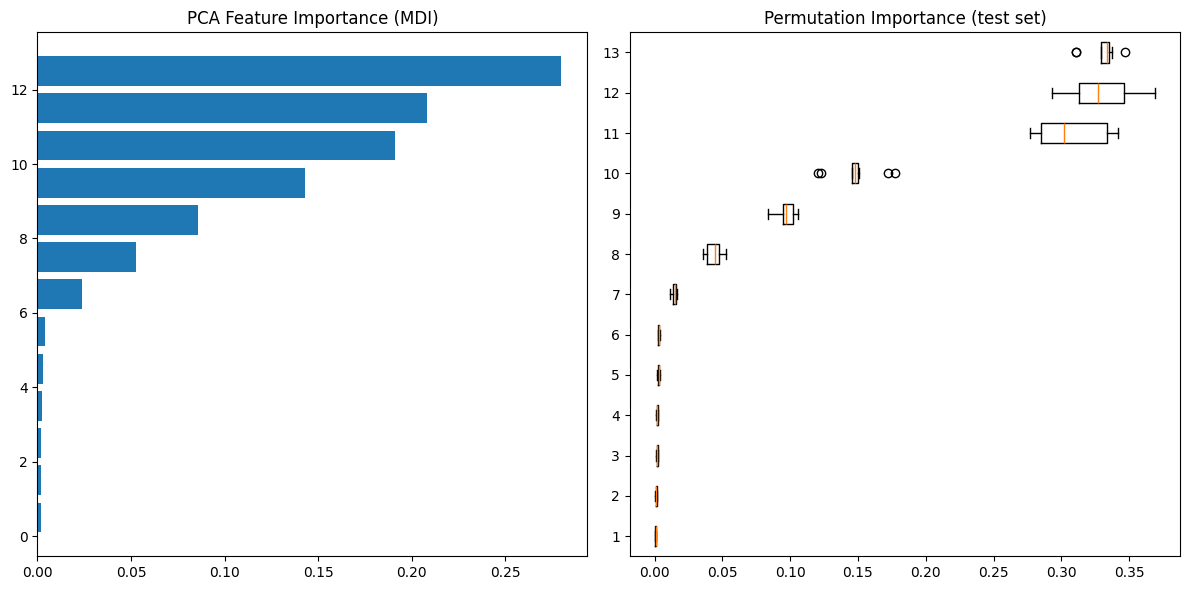

In [236]:
import matplotlib
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version

# Adpated from 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
reg = gb_regressor
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.title("PCA Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)

# `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
# renamed to `tick_labels`. The following code handles this, but as a
# scikit-learn user you probably can write simpler code by using `labels=...`
# (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
tick_labels_parameter_name = (
    "tick_labels"
    if parse_version(matplotlib.__version__) >= parse_version("3.9")
    else "labels"
)
plt.boxplot(result.importances[sorted_idx].T, vert=False)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.savefig(f'{images_path}/GBR_feature_importance.png')
plt.show()

## Gradient boost regression as a good fit

R2 score is 0.92 without scaling. This is quite good.

R2 score is 0.93 with y-scaling. Marginally better.

Moving to a Deep Neural Network model to try and improve performance. 

# Neural Network Model

In [237]:
dim_input = X_test.shape[1]
dim_output = y.shape[1]
print("Xdim", dim_input,"| ydim", dim_output)

Xdim 13 | ydim 1


In [238]:
# https://machinelearningmastery.com/multi-label-classification-with-deep-learning/

# input
layers = [Dense(16, activation='relu'),
          # fork model to predict hardness
          Dense(units=16, activation='relu'),
        #Dense(units=64, activation='relu'),
        #Dense(units=64, activation='relu'),
          # Output layers for each label
          Dense(dim_output, name='Hardness')
]

nn_model = Sequential(layers)

nn_model.compile(optimizer=optimizers.Adam(0.0005),
                 loss='mean_absolute_error',
                 metrics=['mse'])

nn_history = nn_model.fit(x=X_train, y=y_train, 
                        verbose=0, 
                        epochs=100,
                        validation_split = 0.2)


In [239]:
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hardness (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,541 (6.02 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,028 (4.02 KB)

## Evaluate NN model

Inital NN model is slightly worse than a gradient boosted regression

In [240]:
result = nn_model.evaluate(X_test, y_test, return_dict=True)
result

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1918 - mse: 0.0689  


{'loss': 0.1858946979045868, 'mse': 0.06807050853967667}

In [241]:
history_df = pl.DataFrame(nn_history.history)
history_df = history_df.with_row_index()
history_df.tail(3)

index,loss,mse,val_loss,val_mse
u32,f64,f64,f64,f64
97,0.152313,0.050534,0.181568,0.075035
98,0.152947,0.050869,0.183732,0.075848
99,0.151689,0.050383,0.18587,0.076364


In [242]:
def plot_model_history(df, name='DNN', feature='mse', tuner=False):
    title = f'{feature}'.title() if feature != 'mse' else "Mean Squared Error"
    selector = ['index', feature]
    if tuner: selector.append(f'val_{feature}')

    df_reduced = df.select(selector)

    plot = alt.Chart(df_reduced).mark_line().encode(
        alt.X('index').title('Epochs'),
        alt.Y(alt.repeat('layer'), type='quantitative').\
            title(title),
        color = alt.datum(alt.repeat('layer'))
    ).repeat(
        layer = selector[1:]
    ).properties(title=f"{title} by Epoch")

    plot.show()

    plot.save(f"{images_path}/{name}_{feature}.png")


In [243]:
plot_model_history(history_df, feature='mse', name="initial_NN", tuner=True)
plot_model_history(history_df, feature='loss', name="initial_NN", tuner=True)

alt.RepeatChart(...)

alt.RepeatChart(...)

# Results

NN model pushes R2 down to 0.5 with onyl about 25 epochs

# Build a Tuner

In [259]:
name = "hardness_DNN_tuner"
def create_hp_model(hp):
    #Activation for all hidden layers
      activation = hp.Choice('activation',['relu','tanh','sigmoid'])

      layers = [Dense(units=hp.Int('time_units1',
                             min_value=8,
                             max_value=256,
                             sampling='linear'), 
                             activation=activation),
                             # fork model to predict hardness
                  Dense(units=hp.Int('time_units2',
                             min_value=8,
                             max_value=256,
                             sampling='linear'), 
                             activation=activation),
                  Dense(dim_output, name='Hardness')
          ]
    
      nn_model = Sequential(layers)

      nn_model.compile(optimizer=optimizers.Adam(0.01),
                 loss='mean_absolute_error',
                 metrics=['mse'])
    
      return nn_model

In [245]:
tuner = kt.Hyperband(
    create_hp_model,
    objective=["val_loss","val_loss"],
    max_epochs=20,
    factor=5,
    hyperband_iterations=2,
    project_name=name,
    executions_per_trial=5)


Reloading Tuner from ./hardness_DNN_tuner/tuner0.json


In [246]:
tuner.search(x=X_train, 
             y=y_train,
             epochs=250,
             validation_data=(X_test,y_test))

In [247]:
best_model = tuner.get_best_models(1)[0]

/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [248]:
fit_history = best_model.fit(x=X_train, 
               y=y_train, 
               verbose=0,
               epochs=150)

In [249]:
tuner.get_best_hyperparameters(1)[0].values

{'activation': 'relu',
 'time_units1': 189,
 'time_units2': 40,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

In [250]:
history_df = pl.DataFrame(fit_history.history)
history_df = history_df.with_row_index()
history_df.head(3)

index,loss,mse
u32,f64,f64
0,0.144201,0.045265
1,0.140557,0.043875
2,0.135166,0.042452


In [251]:
plot_model_history(history_df, feature='mse', name=name, tuner=False)
plot_model_history(history_df, feature='loss', name=name, tuner=False)

alt.RepeatChart(...)

alt.RepeatChart(...)

# Optimizing optimizer

In [252]:

def create_opt_model(opt):
    #Activation for all hidden layers

    layers = [Dense(units=164, 
                    activation='relu'),
                Dense(units=24, 
                      activation='relu'),
                Dense(dim_output, name='Hardness')
          ]
    
    nn_model = Sequential(layers)

    nn_model.compile(optimizer=opt,
                 loss='mean_absolute_error',
                 metrics=['mse'])
    
    return nn_model

In [253]:
opts = [name.lower() for name in ["Adadelta", 
                                        "Adafactor", 
                                        "Adagrad", 
                                        "Adam", 
                                        "AdamW", 
                                        "Adamax", 
                                        "Ftrl", 
                                        "Lion", 
                                        "Nadam", 
                                        "RMSprop", 
                                        "SGD"]]

In [254]:
for opt in opts:
    best_opt = 'starter'
    best_mse = 4

    model = create_opt_model(opt)
    model.fit(x=X_train, 
            y=y_train,
            verbose=0,
            epochs=150)
    
    loss, mse = nn_model.evaluate(X_test, y_test)
    
    if mse < best_mse:
        best_mse = mse
        best_opt = opt

print("Best Optimizer:", best_opt, "with MSE", best_mse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1918 - mse: 0.0689 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.1918 - mse: 0.0689
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.1918 - mse: 0.0689
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 0.1912 - mse: 0.0687
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.1918 - mse: 0.0689
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.1918 - mse: 0.0689
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.1918 - mse: 0.0689
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.1909 - mse: 0.0687
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.1918 - mse: 0.0689
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.1914 - mse: 0.0686
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.1918 - mse: 0.0689
Best Optimizer: sgd with MSE 0.06807050853967667


## Epoch optimization

In [255]:
model = create_opt_model(optimizers.SGD(0.01))
fit = model.fit(x=X_train, 
         y=y_train, 
         verbose=0,
         epochs=100)



In [256]:
name= 'epoch_test'
history_df = pl.DataFrame(fit.history)
history_df = history_df.with_row_index()
history_df
plot_model_history(history_df, feature='mse', name=name)
plot_model_history(history_df, feature='loss', name=name)

alt.RepeatChart(...)

alt.RepeatChart(...)

# Best Neural Network Model

In [257]:
model = create_opt_model(opt)
fit = model.fit(x=X_train, 
        y=y_train,
        verbose=0,
        epochs=25)

name = 'final_NN'

history_df = pl.DataFrame(fit.history)
history_df = history_df.with_row_index()
history_df

plot_model_history(history_df, feature='mse', name=name)
plot_model_history(history_df, feature='loss', name=name)

alt.RepeatChart(...)

alt.RepeatChart(...)

# Best model, GBR combined with a search

For the Purposes of building an engineering tool that would select the best tempering method to reach a desired hardness, a gradient boost regression should be used. 

From this dataset, an ensamble model would likely be most effective. Use a search tree tests to test pair predictions using the GBR model. This search would uses the predicted hardness difference from the desired hardness as a metric to settle on a set of tempering conditions. 

It is outside the scope of this project, but the XGB model is much less computationally expensive and just as accuracte as the neural network models. An additional piece of infortmation to be fully condifent that would be the best solutions would be to find the worst case search scenario, and how many GBR tests are done. No other system explored here would give satisfactory results however.

In [258]:
#